---
title: "GARCH Volatility Analysis - S&P 500"
---

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## GARCH Volatility Modeling
### Analysis of S&P 500 Volatility Dynamics

This notebook demonstrates advanced volatility modeling techniques using GARCH models
applied to S&P 500 data. We progress from basic univariate GARCH to a
multivariate model and rolling forecast. Lastly, we'll compile for risk management applications. 

Key Analyses:

1. Univariate GARCH modeling and diagnostics

2. Dynamic Conditional Correlation (DCC-GARCH) for multi-asset portfolios

3. Rolling Window Forecasts

4. Risk management applications (VaR, portfolio optimization)

------------------------------------------------------------------------------------------------------

In [1]:
## Setup and Data Preparation
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from arch import arch_model
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import acf
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Less restrictive style
# Set style for professional plots 
plt.style.use('seaborn-v0_8-darkgrid') 
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [24, 20]
plt.rcParams['figure.dpi'] = 150


In [3]:
# Define the date range for data retrieval
start_date = '2019-10-04'
filter_date = '2020-01-01'
end_date = '2024-12-31'
# Define tickers for multi-asset analysis
tickers = {
        'SPY': 'S&P 500 ETF',
        'TLT': '20+ Year Treasury ETF', 
        'GLD': 'Gold ETF',
        'VXX': 'Volatility S&P 500 Index ETF'
    }

ticker_list = list(tickers.keys())  # Display first four tickers for brevity

In [4]:
### Functions will be front-loaded in the notebook before the main analysis. This allows for better organization and readability of the code. ###
### In addition, it ensures that all necessary functions are defined before they are called in the analysis sections. ###

In [5]:
## Function to load market data
def load_market_data(tickers, start_date, end_date):
    """
    Load market data for specified tickers within a date range.
    Returns a DataFrame with adjusted close prices.
    """
    #print(f"Loading market data from {start_date} to {end_date}") <--Not sure I need to print this
    # Load market data
    data = {}
    for ticker, name in tickers.items():
        #print(f"Retrieving data for {name} ({ticker})") <-- Not sure I need to print this
        temp_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        data[ticker] = pd.Series(temp_data['Close'][ticker][:], index=temp_data.index)
        #print(f"Loaded {ticker} ({name}): {len(tickers)} observations") <-- Not sure I need to print this
    
    prices_df = pd.DataFrame.from_dict(data, orient='index').T
    returns_df = prices_df.pct_change().dropna() * 100  # Convert to percentage
    sp500_returns = returns_df['SPY']
    return prices_df, returns_df, sp500_returns

In [6]:
## Function Function to plot explroatory analysis and review results
def create_exploratory_plots(returns, prices):
    """
    Create comprehensive exploratory data analysis plots
    """
    fig = plt.figure()

    # 1. Price evolution
    plt.subplot(3, 2, 1)
    prices['SPY'].plot(color='blue')
    plt.ylabel('Price ($)', fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.title('S&P 500 Price Evolution', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    
    # 2. Returns time series
    plt.subplot(3, 2, 2)
    returns.plot(color='red', alpha=0.7)
    plt.ylabel('Returns (%)', fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.title('S&P 500 Daily Returns', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    
    # 3. Returns distribution
    plt.subplot(3, 2, 3)
    returns.hist(bins=50, density=True, alpha=0.7, color='green')
    
    # Overlay normal distribution
    x = np.linspace(returns.min(), returns.max(), 100)
    normal_dist = stats.norm.pdf(x, returns.mean(), returns.std())
    plt.plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    plt.title('Returns Distribution vs Normal', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('Returns (%)', fontsize=14, fontweight='bold')
    plt.ylabel('Density', fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # 4. Q-Q plot
    plt.subplot(3, 2, 4)
    stats.probplot(returns, dist="norm", plot=plt)
    plt.title('Q-Q Plot: Returns vs Normal Distribution', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.grid(True, alpha=0.3)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    
    # 5. Rolling volatility
    plt.subplot(3, 2, 5)
    rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)
    rolling_vol.plot(color='purple')
    plt.ylabel('Volatility (%)', fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.title('V30-Day Rolling Volatility (Annualized)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    
    # 6. Autocorrelation of squared returns
    plt.subplot(3, 2, 6)

    squared_returns = returns**2
    acf_values = acf(squared_returns, nlags=20, fft=True)
    plt.bar(range(len(acf_values)), acf_values, alpha=0.7)
    plt.title('ACF of Squared Returns (Volatility Clustering)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
    plt.xlabel('Lags', fontsize=14, fontweight='bold')
    plt.ylabel('Autocorrelation', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    

In [7]:
def run_statistical_tests(returns):
    """
    Run statistical tests on the returns data
    """
    # Calculate squared returns for ARCH test
    squared_returns = returns**2
    
    # Normality test
    jb_stat, jb_pvalue, jb_skew, jb_kurtosis = jarque_bera(returns)
    print(f"Jarque-Bera Test for Normality:")
    print(f"  Statistic: {jb_stat:.4f}")
    print(f"  P-value: {jb_pvalue:.6f}")
    print(f"  Result: {'Reject normality' if jb_pvalue < 0.05 else 'Cannot reject normality'}")
    
    # ARCH test (volatility clustering)
    lb_test = acorr_ljungbox(squared_returns, lags=10, return_df=True)
    print(f"\nLjung-Box Test for ARCH Effects (Volatility Clustering):")
    print(f"  P-value (lag 10): {lb_test['lb_pvalue'].iloc[-1]:.6f}")
    print(f"  Result: {'Significant ARCH effects detected' if lb_test['lb_pvalue'].iloc[-1] < 0.05 else 'No ARCH effects'}")

In [8]:
# Function compares GARCH models and returns a DataFrame with results
def compare_garch_models(returns, model_specs):
    results_summary = []
    models = {}
    fitted_models = {}

    for name, specs in model_specs.items():
        vol_model = specs.get('vol', 'GARCH')
        model = arch_model(
                    returns, 
                    vol=vol_model, 
                    p=specs['p'], 
                    q=specs['q'],
                    o=specs.get('o', 0),
                    dist=specs['dist']
                    )
                    
        fitted = model.fit(disp='off')
        models[name] = model
        fitted_models[name] = fitted
                    
        # Store key metrics
        results_summary.append({
                    'Model': name,
                    'AIC': fitted.aic,
                    'BIC': fitted.bic,
                    'Log-Likelihood': fitted.loglikelihood,
                    'Parameters': fitted.num_params
                    })

    # Create comparison table
    model_comparison = pd.DataFrame(results_summary)
    model_comparison = model_comparison.sort_values('AIC')
            
    # Select best model
    best_model_name = model_comparison.iloc[0]['Model']
    best_model = fitted_models[best_model_name]
            
    return fitted_models, model_comparison, best_model_name, best_model

In [9]:
#Function to run model diagnostics on best model determined in the model comparison
def model_diagnostics_plots(best_model_name, fitted_models):
        """
        Comprehensive model diagnostics
        """
        
        fitted_model = fitted_models[best_model_name]

        # Extract residuals
        std_residuals = fitted_model.std_resid
        conditional_vol = fitted_model.conditional_volatility
        fig = plt.figure()
        
        # 1. Standardized residuals over time
        plt.subplot(3, 2, 1)
        plt.plot(std_residuals, alpha=0.7)
        plt.title('Standardized Residuals', fontsize=16, fontweight='bold')
        plt.ylabel('Std. Residuals', fontsize=14, fontweight='bold')
        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)
        plt.grid(True, alpha=0.3)
        
        # 2. Conditional volatility
        plt.subplot(3, 2, 2)
        plt.plot(conditional_vol * np.sqrt(252), color='red')  # Annualized
        plt.title('Conditional Volatility (Annualized)', fontsize=16, fontweight='bold')
        plt.ylabel('Volatility (%)', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)
        
        # 3. Residuals distribution
        plt.subplot(3, 2, 3)
        plt.hist(std_residuals, bins=50, density=True, alpha=0.7)
        x = np.linspace(std_residuals.min(), std_residuals.max(), 100)
        plt.plot(x, stats.norm.pdf(x), 'r-', linewidth=2, label='Normal')
        plt.title('Standardized Residuals Distribution', fontsize=16, fontweight='bold')
        plt.legend(fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)
        
        # 4. Q-Q plot
        plt.subplot(3, 2, 4)
        stats.probplot(std_residuals, dist="norm", plot=plt)
        plt.title('Q-Q Plot: Residuals vs Normal', fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)
        
        # 5. ACF of standardized residuals
        plt.subplot(3, 2, 5)
        acf_resid = acf(std_residuals, nlags=20, fft=True)
        plt.bar(range(len(acf_resid)), acf_resid, alpha=0.7)
        plt.title('ACF of Standardized Residuals', fontsize=16, fontweight='bold')
        plt.xlabel('Lags', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)
        
        # 6. ACF of squared standardized residuals
        plt.subplot(3, 2, 6)
        acf_resid_sq = acf(std_residuals**2, nlags=20, fft=True)
        plt.bar(range(len(acf_resid_sq)), acf_resid_sq, alpha=0.7, color='orange')
        plt.title('ACF of Squared Std. Residuals', fontsize=16, fontweight='bold')
        plt.xlabel('Lags', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.yticks(fontsize=14)
        plt.xticks(fontsize=14)
        
        plt.tight_layout()
        plt.savefig('diagnostics_plot.png', dpi=300)
        plt.show()

        return std_residuals, conditional_vol

In [10]:
#Function to run statistical tests on the standardized residuals of the best model
def run_std_residuals_tests_on_best_model(std_residuals):
        jb_stat, jb_pvalue, jb_skew, jb_kurtosis = jarque_bera(std_residuals)
        print(f"Jarque-Bera (normality): {jb_stat:.4f} (p={jb_pvalue:.6f})")
        
        lb_test = acorr_ljungbox(std_residuals**2, lags=10, return_df=True)
        print(f"Ljung-Box on squared residuals (ARCH): {lb_test['lb_pvalue'].iloc[-1]:.6f}")

In [11]:
#function to evaluate univariate GARCH models for each asset
def create_univariate_models(assets, returns):
    """
    Create univariate GARCH models for each asset in the DataFrame.
    Returns a dictionary of fitted models.
    """
    univariate_models = {}
    for asset in assets:
        model = arch_model(returns[asset], vol='GARCH', p=1, q=1, dist='t')
        fitted = model.fit(disp='off')
        univariate_models[asset] = fitted
    return univariate_models

In [12]:
#Function to generate multivariate GARCH correlations
# This function manually estimates dynamic conditional correlations (DCC) using standardized residuals from univariate GARCH models.
def generate_multivariate_garch_correlations(returns, univariate_models, asset_names, filter_date):
    """
    Manual DCC estimation (simplified version)
    """     
    # Get standardized residuals from univariate models
    std_residuals = pd.DataFrame()
    conditional_vols = pd.DataFrame()
        
    for asset in asset_names:
        std_residuals[asset] = univariate_models[asset].std_resid
        conditional_vols[asset] = univariate_models[asset].conditional_volatility
        
    # Simple DCC estimation using rolling correlation
    window = 60  # 3-month window
    n_assets = len(asset_names)
    n_obs = len(std_residuals)
        
    # Store dynamic correlations
    dynamic_correlations = np.zeros((n_obs, n_assets, n_assets))
    
    # Calculate correlations
    for t in range(window, n_obs):
            # Rolling correlation matrix
            recent_residuals = std_residuals.iloc[t-window:t]
            corr_matrix = recent_residuals.corr().values
            dynamic_correlations[t] = corr_matrix

    """
    Analyze the evolution of correlations over time
    """
    # Extract pairwise correlations
    spy_tlt_corr = [dynamic_correlations[t, 0, 1] for t in range(len(dynamic_correlations))]
    spy_gld_corr = [dynamic_correlations[t, 0, 2] for t in range(len(dynamic_correlations))]
    tlt_gld_corr = [dynamic_correlations[t, 1, 2] for t in range(len(dynamic_correlations))]
        
    # Create DataFrame for analysis
    corr_df = pd.DataFrame({
            'SPY_TLT': spy_tlt_corr,
            'SPY_GLD': spy_gld_corr,
            'TLT_GLD': tlt_gld_corr
        }, index=returns.index)
    corr_df_parsed = corr_df[corr_df.index >= filter_date]  # Filter by date
    
    conditional_vols = conditional_vols[conditional_vols.index >= filter_date]  # Filter by date
    std_residuals = std_residuals[std_residuals.index >= filter_date]  # Filter by date
    # Ensure the DataFrame is aligned with the returns index
   
   
    return corr_df, corr_df_parsed, conditional_vols

In [13]:
#Function to plot dynamic correlations
# This function plots the dynamic correlations, their distribution, and crisis analysis.
def plot_multivariate_correlations(corr_df, returns_df):
    # Plot dynamic correlations
    fig = plt.figure()
            
    # Time series of correlations
    plt.subplot(2, 2, 1)
    plt.plot(corr_df.index, corr_df['SPY_TLT'], label='SPY-TLT', alpha=0.8)
    plt.plot(corr_df.index, corr_df['SPY_GLD'], label='SPY-GLD', alpha=0.8)
    plt.plot(corr_df.index, corr_df['TLT_GLD'], label='TLT-GLD', alpha=0.8)
    plt.title('Dynamic Correlations Over Time', fontsize=16, fontweight='bold')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            
    # Distribution of correlations
    plt.subplot(2, 2, 2)
    plt.hist(corr_df['SPY_TLT'], bins=30, alpha=0.6, label='SPY-TLT')
    plt.hist(corr_df['SPY_GLD'], bins=30, alpha=0.6, label='SPY-GLD')  
    plt.hist(corr_df['TLT_GLD'], bins=30, alpha=0.6, label='TLT-GLD')
    plt.title('Distribution of Dynamic Correlations', fontsize=16, fontweight='bold')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
            
    # Crisis periods analysis (high volatility periods)
    vix_data = returns_df['VXX'].loc[corr_df.index]
    high_vix_periods = vix_data > vix_data.quantile(0.8)
    plt.subplot(2, 2, 3)        
    plt.scatter(vix_data, corr_df['SPY_TLT'], alpha=0.6, s=20)
    plt.xlabel('VIX Level', fontsize=14, fontweight='bold')
    plt.ylabel('SPY-TLT Correlation', fontsize=14, fontweight='bold')
    plt.title('Correlation vs Market Stress (VIX)', fontsize=16, fontweight='bold')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.grid(True, alpha=0.3)
            
    # Rolling average correlations
    plt.subplot(2, 2, 4)
    rolling_corr = corr_df.rolling(window=60).mean()
    plt.plot(rolling_corr.index, rolling_corr['SPY_TLT'], label='SPY-TLT (60d avg)')
    plt.plot(rolling_corr.index, rolling_corr['SPY_GLD'], label='SPY-GLD (60d avg)')
    plt.plot(rolling_corr.index, rolling_corr['TLT_GLD'], label='TLT-GLD (60d avg)')
    plt.title('60-Day Rolling Average Correlations', fontsize=16, fontweight='bold')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
            
    plt.tight_layout()
    plt.savefig('plot_2.png', dpi=300)
    plt.show()

    return corr_df, vix_data, high_vix_periods


In [14]:
def crisis_analysis(corr_df, high_vix_periods):
    """
    Analyze correlations during crisis periods (high VIX)
    """
# Crisis analysis
    crisis_corr = corr_df[high_vix_periods]
    normal_corr = corr_df[~high_vix_periods]
            
    for pair in corr_df.columns:
        crisis_mean = crisis_corr[pair].mean()
        normal_mean = normal_corr[pair].mean()
        print(f"  {pair}: Crisis={crisis_mean:.3f}, Normal={normal_mean:.3f}, Difference={crisis_mean-normal_mean:.3f}")

In [15]:
#Function to calculate portfolio volatility using dynamic correlations
# This function calculates the portfolio volatility using the dynamic correlations and conditional volatilities.
def portfolio_volatility(conditional_vols, corr_df, returns):
    
    print(f"\nPortfolio Optimization Using Dynamic Correlations:")

    # Equal weight portfolio
    weights = np.array([1/3, 1/3, 1/3])  # Equal weights for SPY, TLT, GLD

    # Ensure conditional_vols order matches weights order (SPY, TLT, GLD)
    conditional_vols_ordered = conditional_vols[['SPY', 'TLT', 'GLD']]  # Match weight order

    # Calculate average correlations over the period
    avg_spy_tlt = corr_df['SPY_TLT'].mean()
    avg_spy_gld = corr_df['SPY_GLD'].mean() 
    avg_tlt_gld = corr_df['TLT_GLD'].mean()


    # Fixed correlation matrix
    avg_corr_matrix = np.array([
        [1.0,        avg_spy_tlt, avg_spy_gld],
        [avg_spy_tlt, 1.0,        avg_tlt_gld],
        [avg_spy_gld, avg_tlt_gld, 1.0       ]
    ])

    # Time-varying volatilities with fixed correlations
    portfolio_vol_simple = []
    for date in conditional_vols_ordered.index:
        vol_vector = conditional_vols_ordered.loc[date].values / 100
        vol_matrix = np.outer(vol_vector, vol_vector)
        cov_matrix = avg_corr_matrix * vol_matrix
        port_var = weights.T @ cov_matrix @ weights
        portfolio_vol_simple.append(np.sqrt(port_var * 252) * 100)

    portfolio_vol_series = pd.Series(portfolio_vol_simple, index=conditional_vols_ordered.index)

    # Compare with equal-weighted historical volatility (only investable assets)
    investable_returns = returns[['SPY', 'TLT', 'GLD']]  # Exclude VIX
    equal_weight_returns = investable_returns.mean(axis=1)  # Equal weight portfolio returns
    hist_vol = equal_weight_returns.rolling(60).std() * np.sqrt(252)

    print(f"Average Portfolio Volatility (DCC): {portfolio_vol_series.mean():.2f}%")
    print(f"Average Portfolio Volatility (Historical): {hist_vol.dropna().mean():.2f}%")

    return portfolio_vol_series, hist_vol

In [16]:
#function to perform additional analysis on the portfolio volatility series
# This function performs additional analysis on the portfolio volatility series, including statistics and date range.
def portfolio_analysis(portfolio_vol_series):
    """
    Perform additional analysis on the portfolio volatility series
    """
# Additional analysis
    print(f"Number of observations: {len(portfolio_vol_series)}")
    print(f"Date range: {portfolio_vol_series.index[0].strftime('%Y-%m-%d')} to {portfolio_vol_series.index[-1].strftime('%Y-%m-%d')}")

    # Show volatility statistics
    print(f"DCC Portfolio Volatility:")
    print(f"  Mean: {portfolio_vol_series.mean():.2f}%")
    print(f"  Std:  {portfolio_vol_series.std():.2f}%")
    print(f"  Min:  {portfolio_vol_series.min():.2f}%")
    print(f"  Max:  {portfolio_vol_series.max():.2f}%")

In [17]:
# Function to plot conditional volatility and apply DCC results to portfolio optimization
# This function plots the conditional volatility and applies DCC results to portfolio optimization.
def plot_conditional_volatility(portfolio_vol_series, hist_vol):
    """
    Apply DCC results to portfolio optimization
    """

    # Plot comparison
    plt.figure(figsize=(20, 10))
    plt.plot(portfolio_vol_series.index, portfolio_vol_series, 
            label='DCC-GARCH Portfolio Volatility', linewidth=2, color='blue')
    plt.plot(hist_vol.index, hist_vol, 
            label='Historical 60-day Rolling Volatility', alpha=0.7, color='tomato')
    plt.title('Portfolio Volatility: DCC-GARCH vs Historical Methods', fontsize=16, fontweight='bold')
    plt.ylabel('Annualized Volatility (%)', fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('portfolio_volatility_plot.png', dpi=300)
    plt.show()
    

In [18]:
# Function to perform simple rolling GARCH forecasting
# This function performs a simple rolling GARCH forecast using a specified window size and forecast horizon.
def simple_rolling_forecast(returns, window_size, forecast_horizon, step):
    """
    Simple rolling window GARCH forecasting
    
    Parameters:
    - returns: pandas Series of daily returns
    - window_size: size of rolling window (default 252 = 1 year)
    - forecast_horizon: days ahead to forecast (default 30)
    - step: how often to forecast (default every 10 days)
    """
    
    # Storage for results
    forecast_dates = []
    volatility_forecasts = []
    actual_volatilities = []
    
    # Start after we have enough data for window
    start_idx = window_size
    end_idx = len(returns) - forecast_horizon
    
    # Simple for loop
    for i in range(start_idx, end_idx, step):
        
        # Get window data
        window_data = returns.iloc[i-window_size:i]
        forecast_date = returns.index[i]
        
        try:
            # Fit GARCH model
            model = arch_model(window_data, vol='GARCH', p=1, q=1, dist='t')
            fitted = model.fit(disp='off')
            
            # Get forecast
            forecast = fitted.forecast(horizon=forecast_horizon)
            vol_forecast = np.sqrt(forecast.variance.iloc[0, 0] * 252)  # Annualized
            
            # Get actual future volatility
            future_data = returns.iloc[i:i+forecast_horizon]
            actual_vol = future_data.std() * np.sqrt(252)  # Annualized
            
            # Store results
            forecast_dates.append(forecast_date)
            volatility_forecasts.append(vol_forecast)
            actual_volatilities.append(actual_vol)
            
            #print(f"{forecast_date.strftime('%Y-%m-%d')}: Forecast={vol_forecast:.2f}%, Actual={actual_vol:.2f}%")
            
        except Exception as e:
            print(f"Error at {forecast_date}: {e}")
            continue
    
    # Create DataFrame
    forecast_df = pd.DataFrame({
        'Volatility_Forecast': volatility_forecasts,
        'Actual_Volatility': actual_volatilities
    }, index=forecast_dates)
    
    print(f"\n✓ Generated {len(forecast_df)} forecasts")
    return forecast_df

In [19]:
#Function to evaluate the accuracy of rolling forecasts
# This function evaluates the accuracy of rolling forecasts using various metrics.
def evaluate_forecast_accuracy(returns, forecast_df):
    """
    Evaluate the accuracy of rolling forecasts
    """
        
    # Remove NaN values
    valid_data = forecast_df.dropna()
        
    forecasts = valid_data['Volatility_Forecast']
    actuals = valid_data['Actual_Volatility']
        
    # Calculate accuracy metrics
    mae = np.mean(np.abs(forecasts - actuals))
    rmse = np.sqrt(np.mean((forecasts - actuals)**2))
    mape = np.mean(np.abs((forecasts - actuals) / actuals)) * 100
    correlation = np.corrcoef(forecasts, actuals)[0, 1]
        
    # Direction accuracy (whether forecast correctly predicted increase/decrease)
    prev_vol = returns.rolling(30).std().iloc[-len(valid_data):] * np.sqrt(252) * 100
    actual_direction = (actuals > prev_vol.values).astype(int)
    forecast_direction = (forecasts > prev_vol.values).astype(int)
    direction_accuracy = np.mean(actual_direction == forecast_direction) * 100
        
    # Store accuracy metrics
    accuracy_metrics = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'Correlation': correlation,
            'Direction_Accuracy': direction_accuracy,
            'N_Observations': len(valid_data)
        }
        
    print(f"Forecast Accuracy Metrics:")
    print(f"  Mean Absolute Error (MAE): {mae:.3f}%")
    print(f"  Root Mean Square Error (RMSE): {rmse:.3f}%")
    print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"  Correlation: {correlation:.4f}")
    print(f"  Direction Accuracy: {direction_accuracy:.2f}%")
    print(f"  Number of Observations: {len(valid_data)}")
        
    return accuracy_metrics

In [20]:
#function to plot forecast analysis
# This function creates comprehensive plots to analyze the forecast results.
def plot_forecast_analysis(forecast_df):
    """
    Create comprehensive forecast analysis plots
    """
    fig = plt.figure()
        
    # Remove NaN values for plotting
    valid_data = forecast_df.dropna()
        
    # 1. Forecast vs Actual over time
    plt.subplot(2, 2, 1)
    plt.plot(valid_data.index, valid_data['Volatility_Forecast'], 
                       label='GARCH Forecast', alpha=0.8, linewidth=2)
    plt.plot(valid_data.index, valid_data['Actual_Volatility'], 
                       label='Realized Volatility', alpha=0.8, linewidth=2)
    plt.title('Volatility Forecasts vs Realized Volatility', fontsize=16, fontweight='bold')
    plt.ylabel('Annualized Volatility (%)', fontsize=14, fontweight='bold')
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
        
    # 2. Scatter plot: Forecast vs Actual
    plt.subplot(2, 2, 2)
    plt.scatter(valid_data['Volatility_Forecast'], valid_data['Actual_Volatility'], 
                          alpha=0.6, s=30)
        
    # Add perfect forecast line
    min_val = min(valid_data['Volatility_Forecast'].min(), valid_data['Actual_Volatility'].min())
    max_val = max(valid_data['Volatility_Forecast'].max(), valid_data['Actual_Volatility'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Forecast')
        
    plt.xlabel('Forecast Volatility (%)', fontsize=14, fontweight='bold')
    plt.ylabel('Actual Volatility (%)', fontsize=14, fontweight='bold')
    plt.title('Forecast vs Actual Volatility', fontsize=16, fontweight='bold')
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
        
    # 3. Forecast errors over time
    plt.subplot(2, 2, 3)
    forecast_errors = valid_data['Volatility_Forecast'] - valid_data['Actual_Volatility']
    plt.plot(valid_data.index, forecast_errors, alpha=0.7, color='red')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Forecast Errors Over Time', fontsize=16, fontweight='bold')
    plt.ylabel('Forecast Error (%)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
        
    # 4. Distribution of forecast errors
    plt.subplot(2, 2, 4)
    plt.hist(forecast_errors, bins=30, alpha=0.7, density=True, color='orange')
    plt.axvline(forecast_errors.mean(), color='red', linestyle='--', 
                          label=f'Mean: {forecast_errors.mean():.3f}%')
    plt.title('Distribution of Forecast Errors', fontsize=16, fontweight='bold')
    plt.xlabel('Forecast Error (%)', fontsize=14, fontweight='bold')
    plt.ylabel('Density', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()
        
    return valid_data

In [21]:
#Function to calculate dynamic VaR using GARCH forecasts
# This function calculates the dynamic Value at Risk (VaR) using GARCH forecasts.
def calculate_dynamic_var(garch_model, confidence_levels, horizon, distribution):
    """
    Simple dynamic VaR calculation using GARCH forecasts
    """
    
    print(f"Calculating Dynamic VaR ({horizon}-day horizon)")
    print(f"Confidence levels: {[int(cl*100) for cl in confidence_levels]}%")
    print(f"Distribution: {distribution}")
    print("-" * 50)
    
    # Get volatility forecast
    forecast = garch_model.forecast(horizon=horizon)
    vol_forecast = np.sqrt(forecast.variance.iloc[-1, 0])  # Already in % if returns were in %
    
    print(f"Volatility forecast: {vol_forecast:.3f}%")
    
    # Calculate VaR for each confidence level
    var_results = {}
    
    for conf_level in confidence_levels:
        
        # Calculate quantiles
        if distribution == 'normal':
            quantile = stats.norm.ppf(1 - conf_level)
        elif distribution == 't':
            df = 6  # Typical degrees of freedom for financial data
            quantile = stats.t.ppf(1 - conf_level, df)
        else:
            quantile = stats.norm.ppf(1 - conf_level)  # Default to normal
        
        # Calculate VaR (no extra *100 since vol_forecast is already in %)
        var_value = quantile * vol_forecast
        
        # Store results
        var_results[conf_level] = {
            'VaR': var_value,
            'Volatility_Forecast': vol_forecast,
            'Quantile': quantile
        }
        
        # Print results
        print(f"{conf_level*100:.0f}% VaR: {var_value:.3f}%")
    
    print("-" * 50)
    
    return var_results

In [22]:
def calculate_portfolio_var(garch_model, portfolio_value, confidence_levels=[0.95, 0.99], 
                          horizon=1, distribution='t'):
    """
    Calculate portfolio VaR in dollar terms
    """
    
    # Get percentage VaR
    var_results = calculate_dynamic_var(garch_model, confidence_levels, horizon, distribution)
    
    print(f"\nPortfolio VaR (Portfolio Value: ${portfolio_value:,.0f})")
    print("-" * 50)
    
    # Convert to dollar terms
    for conf_level in confidence_levels:
        var_pct = var_results[conf_level]['VaR']
        var_dollar = abs(var_pct / 100 * portfolio_value)  # var_pct already in %, so divide by 100
        
        var_results[conf_level]['VaR_Dollar'] = var_dollar
        
        print(f"{conf_level*100:.0f}% VaR: {var_pct:.3f}% = ${var_dollar:,.0f}")
    
    print("-" * 50)
    
    return var_results

In [23]:
def create_var_summary_table(var_results):
    """
    Create a clean summary table of VaR results
    """
    
    # Convert to DataFrame for nice display
    summary_data = []
    
    for conf_level, results in var_results.items():
        row = {
            'Confidence Level': f"{conf_level*100:.0f}%",
            'VaR (%)': f"{results['VaR']:.3f}%",
            'Volatility Forecast (%)': f"{results['Volatility_Forecast']:.3f}%"
        }
        
        # Add dollar VaR if available
        if 'VaR_Dollar' in results:
            row['VaR ($)'] = f"${results['VaR_Dollar']:,.0f}"
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    
    print("\nVaR Summary Table:")
    print("=" * 60)
    print(summary_df.to_string(index=False))
    print("=" * 60)

    # Add interpretation
    print("\nInterpretation:")
    for conf_level, results in var_results.items():
        prob = (1 - conf_level) * 100
        var_pct = abs(results['VaR'])
        if 'VaR_Dollar' in results:
            var_dollar = results['VaR_Dollar']
            print(f"• {prob:.0f}% chance of daily loss exceeding {var_pct:.2f}% (${var_dollar:,.0f})")
        else:
            print(f"• {prob:.0f}% chance of daily loss exceeding {var_pct:.2f}%")
    
    return summary_df

In [24]:
def calculate_scenario_var(volatility_pct, confidence_level, distribution='t'):
    """
    Calculate VaR for a given volatility scenario
    
    Parameters:
    - volatility_pct: Annual volatility percentage
    - confidence_level: Confidence level (e.g., 0.95)
    - distribution: 't' or 'normal'
    """
    
    # Convert annual volatility to daily
    daily_vol = volatility_pct / np.sqrt(252)
    
    # Calculate quantile
    if distribution == 't':
        df = 6  # Standard assumption for financial data
        quantile = stats.t.ppf(1 - confidence_level, df)
    else:
        quantile = stats.norm.ppf(1 - confidence_level)
    
    # Daily VaR
    daily_var = quantile * daily_vol
    
    return daily_var

In [25]:
def calculate_scenario_var_from_daily(daily_vol_pct, confidence_level, distribution='t'):
    """
    Calculate VaR directly from daily volatility percentage
    """
    
    # Calculate quantile
    if distribution == 't':
        df = 6  # Standard assumption for financial data
        quantile = stats.t.ppf(1 - confidence_level, df)
    else:
        quantile = stats.norm.ppf(1 - confidence_level)
    
    # Calculate VaR
    var_value = quantile * daily_vol_pct
    
    return var_value

In [26]:
def display_stress_results(scenarios):
    """
    Display stress test results in a clean format
    """
    
    print("\nSTRESS TEST RESULTS")
    print("-" * 80)
    
    for scenario_name, scenario in scenarios.items():
        print(f"\n{scenario_name.replace('_', ' ').upper()}:")
        print(f"  Description: {scenario['description']}")
        print(f"  Annual Volatility: {scenario['volatility']:.1f}%")
        print(f"  95% Daily VaR: {scenario['var_95']:.2f}% (${scenario['var_95_dollar']:,.0f})")
        print(f"  99% Daily VaR: {scenario['var_99']:.2f}% (${scenario['var_99_dollar']:,.0f})")
        print(f"  Expected Annual Loss: {scenario['expected_annual_loss']:.1f}% (${scenario['annual_loss_dollar']:,.0f})")
    
    print("\n" + "="*80)

In [27]:
def simple_stress_testing(garch_model, returns_data, portfolio_value=1000000):
    """
    Simple stress testing scenarios using GARCH model
    """
    
    print("STRESS TESTING SCENARIOS")
    print("="*60)
    print(f"Portfolio Value: ${portfolio_value:,.0f}")
    print("="*60)
    
     # Get 1-day forecast (same as dynamic VaR)
    single_day_forecast = garch_model.forecast(horizon=1)
    base_daily_vol = np.sqrt(single_day_forecast.variance.iloc[-1, 0])
    
    # Current market conditions
    current_vol = returns_data.tail(30).std() * np.sqrt(252)  # Last 30 days annualized
    
    scenarios = {}
    base_annual_vol = base_daily_vol * np.sqrt(252)
    scenarios['Base_Case'] = {
        'description': 'Normal market conditions (1-day GARCH forecast)',
        'volatility': base_annual_vol,  # Use daily vol directly
        'var_95': calculate_scenario_var_from_daily(base_daily_vol, 0.95),
        'var_99': calculate_scenario_var_from_daily(base_daily_vol, 0.99),
        'expected_annual_loss': base_annual_vol * 0.4
    }
    
    # Scenario 2: Moderate Stress (1.5x current volatility)
    moderate_stress_vol = current_vol * 1.5
    scenarios['Moderate_Stress'] = {
        'description': '1.5x current market volatility',
        'volatility': moderate_stress_vol,
        'var_95': calculate_scenario_var_from_daily(moderate_stress_vol, 0.95),
        'var_99': calculate_scenario_var_from_daily(moderate_stress_vol, 0.99),
        'expected_annual_loss': moderate_stress_vol * 0.4
    }
    
    # Scenario 3: Severe Stress (2008-like crisis)
    crisis_vol = 45.0  # Typical 2008 crisis volatility
    scenarios['Crisis_2008'] = {
        'description': '2008-style financial crisis (45% volatility)',
        'volatility': crisis_vol,
        'var_95': calculate_scenario_var_from_daily(crisis_vol, 0.95),
        'var_99': calculate_scenario_var_from_daily(crisis_vol, 0.99),
        'expected_annual_loss': crisis_vol * 0.6  # Higher loss rate in crisis
    }
    
    # Scenario 4: Extreme Stress (COVID-like event)
    covid_vol = 60.0  # March 2020 levels
    scenarios['Extreme_COVID'] = {
        'description': 'COVID-style market shock (60% volatility)',
        'volatility': covid_vol,
        'var_95': calculate_scenario_var_from_daily(covid_vol, 0.95),
        'var_99': calculate_scenario_var_from_daily(covid_vol, 0.99),
        'expected_annual_loss': covid_vol * 0.8  # Very high loss rate
    }
    
    # Calculate dollar impacts
    for scenario_name, scenario in scenarios.items():
        scenario['var_95_dollar'] = abs(scenario['var_95'] / 100 * portfolio_value)
        scenario['var_99_dollar'] = abs(scenario['var_99'] / 100 * portfolio_value)
        scenario['annual_loss_dollar'] = scenario['expected_annual_loss'] / 100 * portfolio_value
    
    # Display results
    display_stress_results(scenarios)
    
    
    return scenarios

In [28]:
def print_dashboard_summary(garch_model, returns_data, var_95, var_99):
    """
    Print key risk metrics summary
    """
    
    print("\n" + "="*60)
    print("RISK DASHBOARD SUMMARY")
    print("="*60)
    
    # Current metrics
    current_forecast = garch_model.forecast(horizon=1)
    current_vol = np.sqrt(current_forecast.variance.iloc[-1, 0] * 252)
      # Historical metrics
    hist_vol_30d = returns_data.tail(30).std() * np.sqrt(252)
    hist_vol_1y = returns_data.tail(252).std() * np.sqrt(252)
    
    print(f"Current Volatility Forecast: {current_vol:.2f}%")
    print(f"30-Day Realized Volatility: {hist_vol_30d:.2f}%")
    print(f"1-Year Realized Volatility: {hist_vol_1y:.2f}%")
    print(f"\n95% VaR (1-day): {abs(var_95):.2f}%")
    print(f"99% VaR (1-day): {abs(var_99):.2f}%")
    
    # Risk assessment
    print(f"\nRisk Assessment:")
    if current_vol > hist_vol_1y * 1.5:
        print("⚠️  HIGH RISK: Current volatility significantly above historical average")
    elif current_vol > hist_vol_1y * 1.2:
        print("🟡 MODERATE RISK: Current volatility elevated")
    else:
        print("✅ NORMAL RISK: Current volatility within normal range")
    
    print("="*60)

In [29]:
def create_simple_risk_dashboard(garch_model, returns_data, title="GARCH Risk Management Dashboard"):
    """
    Create a clean, simple risk management dashboard
    """
    
    print(f"Creating {title}...")
    
    # Set up the dashboard
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    # 1. Historical Volatility
    hist_vol = returns_data.rolling(30).std() * np.sqrt(252)  # Annualized
    
    axes[0, 0].plot(hist_vol.index, hist_vol, label='30-Day Rolling Volatility', 
                    color='blue', alpha=0.8)
    axes[0, 0].set_title('Historical Volatility (30-Day Rolling)')
    axes[0, 0].set_ylabel('Annualized Volatility (%)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add current forecast line
    current_forecast = garch_model.forecast(horizon=1)
    print(current_forecast)
    current_vol = np.sqrt(current_forecast.variance.iloc[-1, 0] * 252)
    axes[0, 0].axhline(y=current_vol, color='red', linestyle='--', 
                       label=f'Current GARCH Forecast: {current_vol:.1f}%')
    axes[0, 0].legend()
    
    # 2. Simple VaR Display
    vol_forecast = np.sqrt(current_forecast.variance.iloc[-1, 0])
    var_95 = stats.t.ppf(0.05, df=6) * vol_forecast
    var_99 = stats.t.ppf(0.01, df=6) * vol_forecast
    
    var_levels = ['95% VaR', '99% VaR']
    var_values = [abs(var_95), abs(var_99)]
    colors = ['orange', 'red']
    
    bars = axes[0, 1].bar(var_levels, var_values, color=colors, alpha=0.7)
    axes[0, 1].set_title('Current Value at Risk')
    axes[0, 1].set_ylabel('VaR (%)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, var_values):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    # 3. Return Distribution
    axes[0, 2].hist(returns_data, bins=50, density=True, alpha=0.7, 
                    color='skyblue', label='Actual Returns')
    
    # Overlay normal distribution
    x = np.linspace(returns_data.min(), returns_data.max(), 100)
    normal_dist = stats.norm.pdf(x, returns_data.mean(), returns_data.std())
    axes[0, 2].plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    
    axes[0, 2].set_title('Return Distribution vs Normal')
    axes[0, 2].set_xlabel('Returns (%)')
    axes[0, 2].set_ylabel('Density')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Volatility Clustering Evidence
    squared_returns = returns_data**2
    acf_values = acf(squared_returns, nlags=20, fft=True)
    
    axes[1, 0].bar(range(len(acf_values)), acf_values, alpha=0.7, color='green')
    axes[1, 0].set_title('Volatility Clustering (ACF of Squared Returns)')
    axes[1, 0].set_xlabel('Lags')
    axes[1, 0].set_ylabel('Autocorrelation')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 5. GARCH Model Residuals
    std_residuals = garch_model.std_resid
    axes[1, 1].plot(std_residuals.index, std_residuals, alpha=0.7, color='purple')
    axes[1, 1].set_title('GARCH Standardized Residuals')
    axes[1, 1].set_ylabel('Standardized Residuals')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 6. GARCH Conditional Volatility
    conditional_vol = garch_model.conditional_volatility * np.sqrt(252)
    axes[1, 2].plot(conditional_vol.index, conditional_vol, color='red', alpha=0.8)
    axes[1, 2].set_title('GARCH Conditional Volatility')
    axes[1, 2].set_ylabel('Annualized Volatility (%)')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print_dashboard_summary(garch_model, returns_data, var_95, var_99)
    
    return fig

In [30]:
def create_portfolio_risk_summary(returns_df, portfolio_weights=None, asset_names=None):
    """
    Create simple portfolio risk summary
    """
    
    if asset_names is None:
        asset_names = returns_df.columns.tolist()
    
    if portfolio_weights is None:
        n_assets = len(asset_names)
        portfolio_weights = np.array([1/n_assets] * n_assets)
    
    print("\n" + "="*50)
    print("PORTFOLIO RISK SUMMARY")
    print("="*50)
    
    # Individual asset risk
    individual_vols = returns_df.std() * np.sqrt(252)
    
    print("Individual Asset Volatilities:")
    for i, asset in enumerate(asset_names):
        weight = portfolio_weights[i] * 100
        vol = individual_vols.iloc[i]
        print(f"  {asset}: {vol:.2f}% (Weight: {weight:.1f}%)")
    
    # Portfolio risk
    portfolio_returns = (returns_df * portfolio_weights).sum(axis=1)
    portfolio_vol = portfolio_returns.std() * np.sqrt(252)
    
    print(f"\nPortfolio Volatility: {portfolio_vol:.2f}%")
    
    # Correlation matrix
    corr_matrix = returns_df.corr()
    print(f"\nCorrelation Matrix:")
    print(corr_matrix.round(3))
    
    # Diversification benefit
    weighted_avg_vol = np.sum(individual_vols * portfolio_weights)
    diversification_benefit = weighted_avg_vol - portfolio_vol
    
    print(f"\nDiversification Analysis:")
    print(f"  Weighted Average Volatility: {weighted_avg_vol:.2f}%")
    print(f"  Portfolio Volatility: {portfolio_vol:.2f}%")
    print(f"  Diversification Benefit: {diversification_benefit:.2f}%")
    
    print("="*50)
    
    return {
        'portfolio_vol': portfolio_vol,
        'individual_vols': individual_vols,
        'diversification_benefit': diversification_benefit,
        'correlation_matrix': corr_matrix
    }

In [31]:
# executing the function to load market data
prices, returns, sp500_returns_ = load_market_data(tickers, start_date, end_date)

In [32]:
#filter out first 60 days - will use in multivariate GARCH model and correlations analysis
prices_df = prices[prices.index >= filter_date]
returns_df = returns[returns.index >= filter_date]
sp500_returns = sp500_returns_[sp500_returns_.index >= filter_date]

In [33]:
print(f"Daily S&P 500 returns were loaded for the period from {filter_date} to {end_date}.")
print(f"Additional tickers were loaded for the same period: {ticker_list[1]}, {ticker_list[2]}, and {ticker_list[3]}. These will be \nused in the multivariate analysis.")

Daily S&P 500 returns were loaded for the period from 2020-01-01 to 2024-12-31.
Additional tickers were loaded for the same period: TLT, GLD, and VXX. These will be 
used in the multivariate analysis.


## 1. S&P Summary Statistics and Exploratory Data Analysis
### 1.1 S&P 500 Summary Statistics and Analysis

In [34]:
print("\033[1mS&P 500 summary statistics results are the following:\033[0m")

S&P 500 summary statistics results are the following:


In [35]:
print(f"Mean: {sp500_returns.mean():.4f}%")
print(f"Std Dev: {sp500_returns.std():.4f}%")
print(f"Skewness: {sp500_returns.skew():.4f}")
print(f"Kurtosis: {sp500_returns.kurtosis():.4f}")
print(f"Min: {sp500_returns.min():.4f}%")
print(f"Max: {sp500_returns.max():.4f}%")

Mean: 0.0628%
Std Dev: 1.3229%
Skewness: -0.5443
Kurtosis: 11.5024
Min: -10.9424%
Max: 9.0603%


In [36]:
print("\n")
print("\033[1mS&P 500 analysis of summary statistics:\033[0m")



S&P 500 analysis of summary statistics:


The S&P 500 daily returns resemble the characteristics of typical financial time series data, with an average daily return of 0.0628%, or approximately 16% annualized. The standard deviation of 1.32% represents moderate daily volatility, while the negative skewness of -0.54 reveals a slight tendency toward larger negative returns than positive returns. The excess kurtosis of 11.50 demonstrates significant fat tails as the baseline kurtosis is 3.0, resulting in an excess of 8.50. This high kurtosis, combined with negative skewness (-0.54), indicates the S&P 500 has frequent small gains, occasional large losses, and reflects extreme events occurring more frequently than normal distribution theory would predict. This is evidenced by the wide range between the observed minimum and maximum from -10.94% to +9.06%. Finally, this confirms the presence of volatility clustering and suggests that traditional risk models assuming normal distributions may underestimate tail risks for this period of the portfolio.

### 1.2 Exploratory Data Analysis and Visualizations

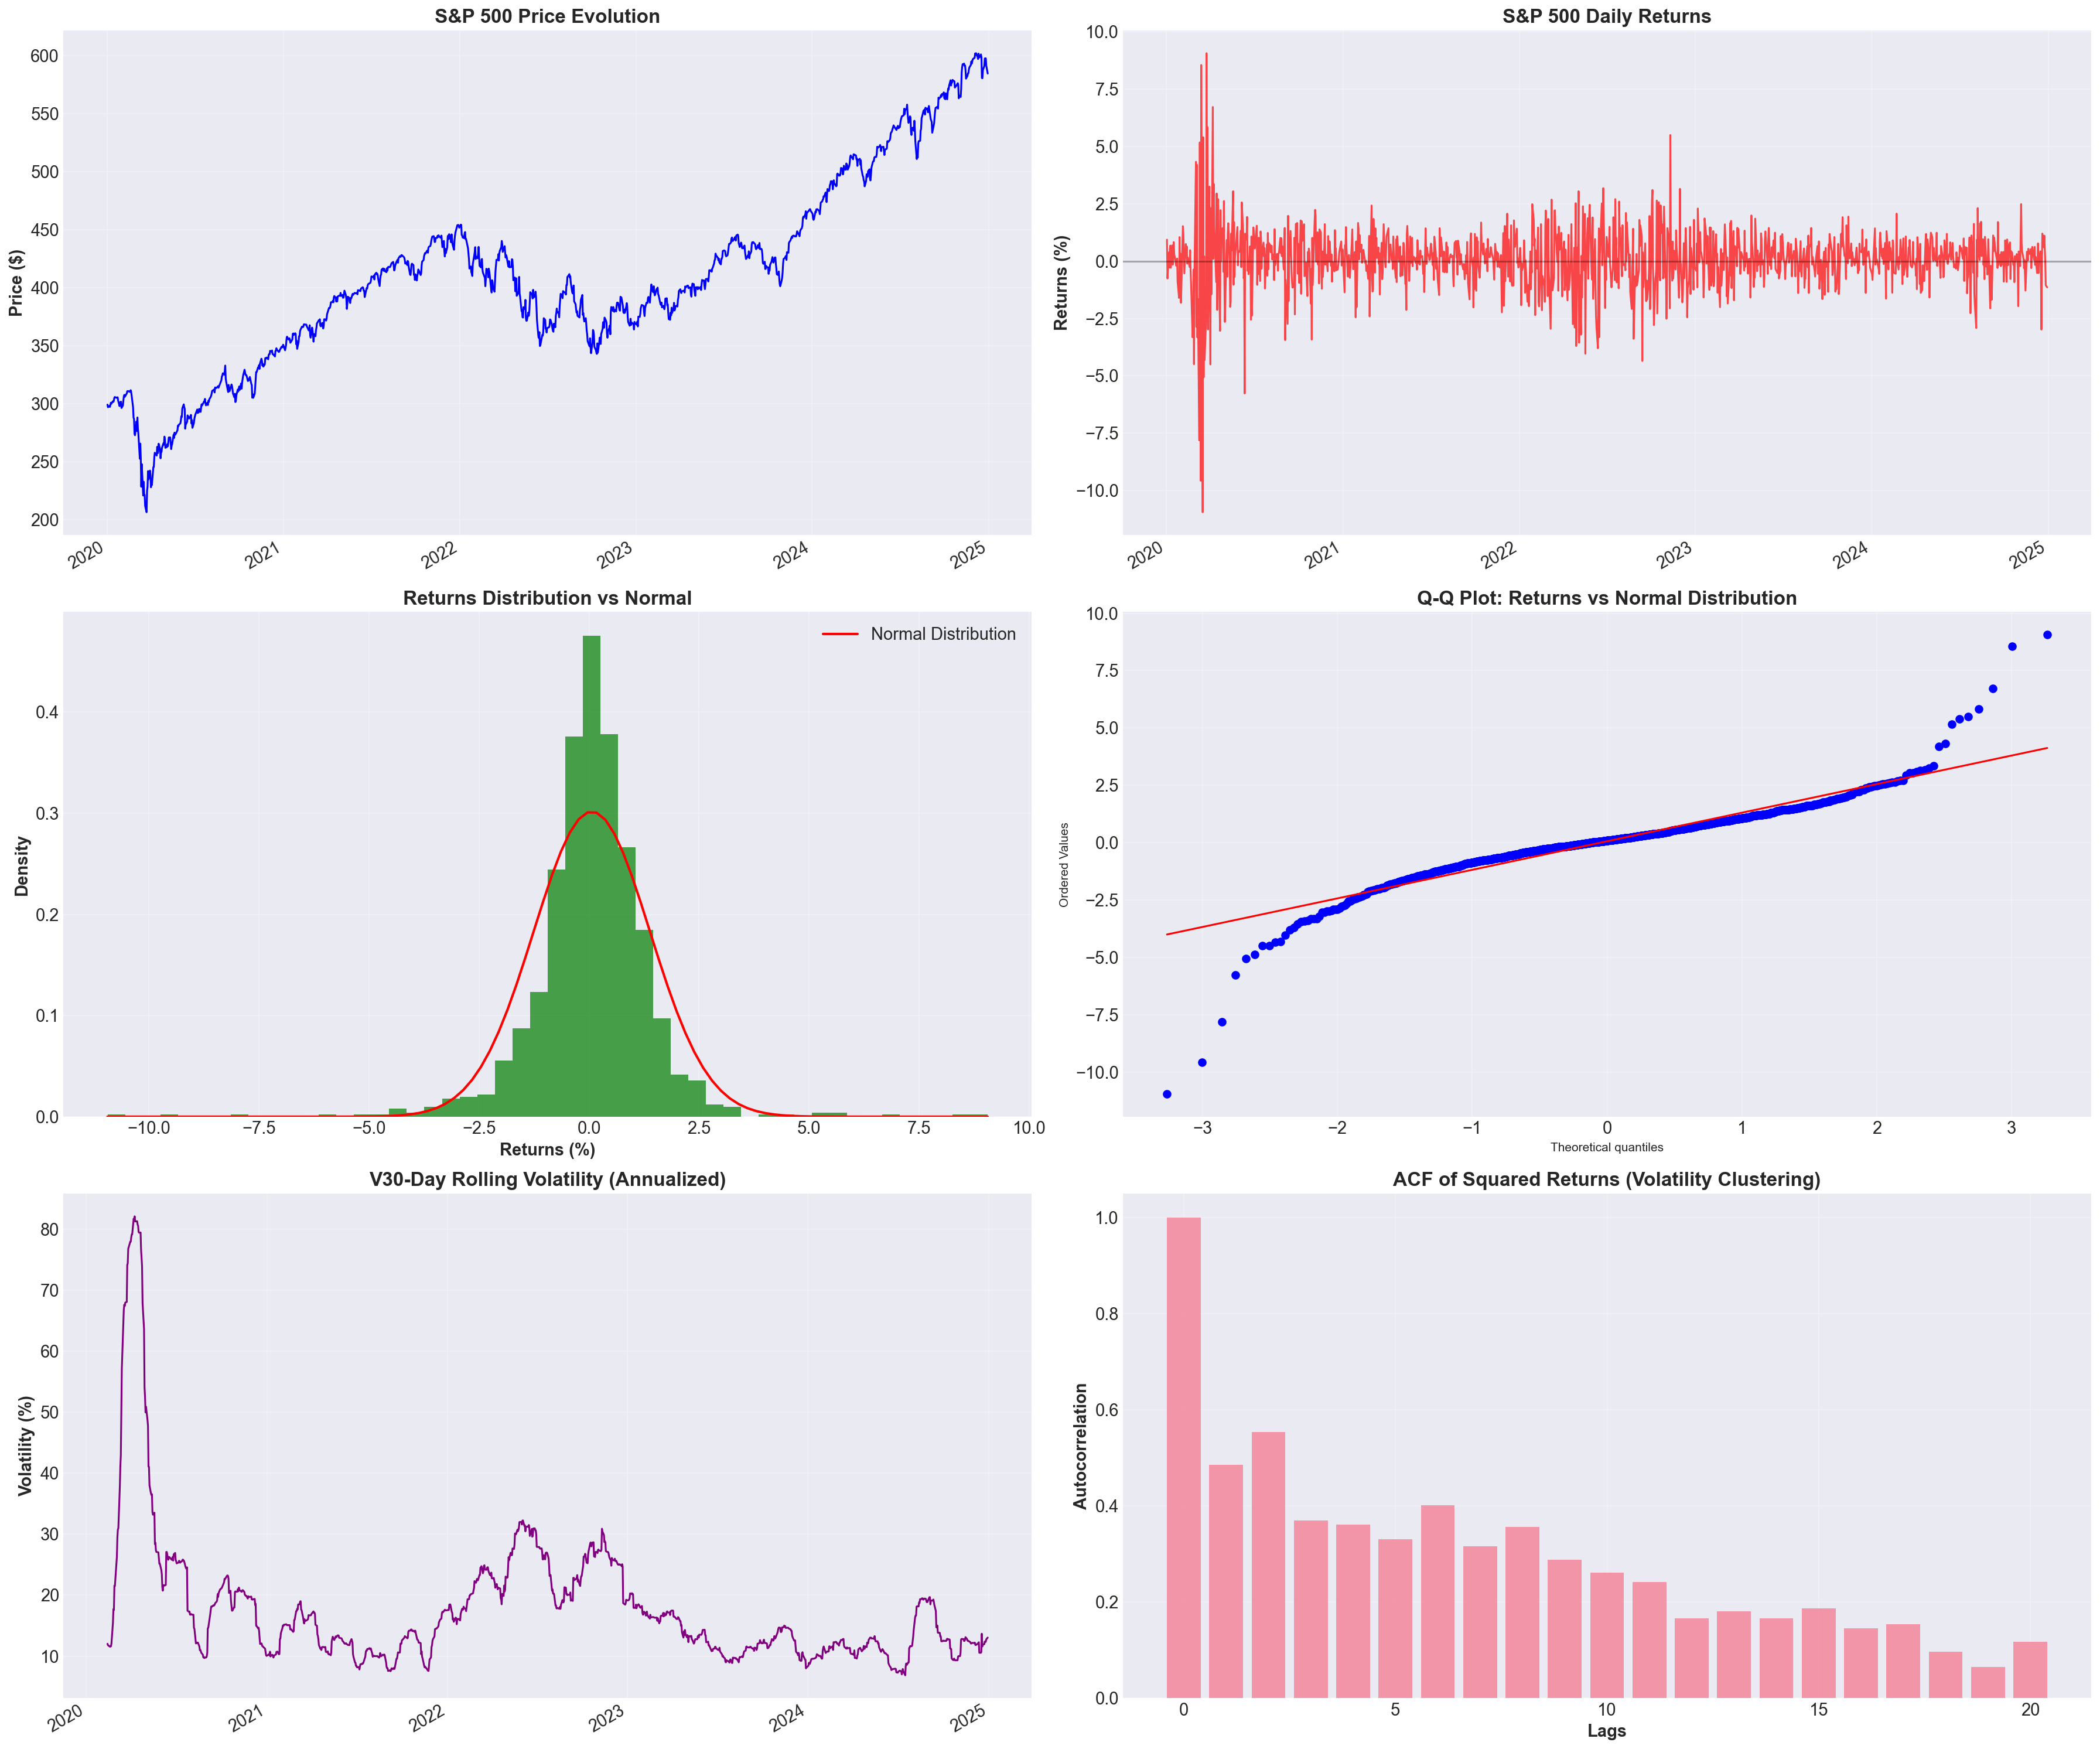

In [37]:
exploratory_plots = create_exploratory_plots(sp500_returns, prices_df)

S&P 500 price evolution shows an increase of nearly 200% from $300 to around $600. While demonstrating strong long-term growth, the data reveals two distinct periods of significant volatility clustering: early-to-mid 2020 during the COVID market crash, and throughout most of 2022 amid aggressive interest rate increases. This clustering behavior is clearly visible in the daily returns plot, where periods of high volatility (large price swings) are followed by continued high volatility, and calm periods persist for extended timeframes. The returns distribution and Q-Q plot confirm substantial deviations from normality, particularly in the tails, indicating the presence of extreme market events that occur more frequently than a normal distribution would predict.
The 30-day rolling volatility and autocorrelation function (ACF) of squared returns provide deeper insight into this volatility clustering phenomenon. The rolling volatility shows sustained high-volatility periods reaching 80% annualized during COVID and elevated levels throughout 2022, while the ACF demonstrates strong persistence in volatility shocks—when markets become volatile, they tend to remain volatile for weeks rather than quickly reverting to calm conditions. As evidence, the ACF shows volatility remaining elevated even at 20-day lags. This persistent volatility clustering validates the use of GARCH modeling to capture these time-varying risk dynamics that traditional models assuming constant volatility would miss.

### 1.3 Statistical Tests

In [38]:
print("\033[1mStatistical Test Results:\033[0m")

Statistical Test Results:


In [39]:
stat_tests = run_statistical_tests(sp500_returns)

Jarque-Bera Test for Normality:
  Statistic: 6930.7051
  P-value: 0.000000
  Result: Reject normality

Ljung-Box Test for ARCH Effects (Volatility Clustering):
  P-value (lag 10): 0.000000
  Result: Significant ARCH effects detected


The Jargue-Bera and Ljung-Box tests results appear to be typical and expected for financial data with high volatility clustering.  The Jarque-Bera tests rejects normality, which is appropriate given the data’s slight skew of -0.54 and fat tails, as indicated in the Q-Q plot. The Ljung-Box test strongly rejects the null hypothesis meaning periods of high volatility tend to be followed by more high volatility, and periods of low volatility tend to be followed by more low volatility. This clustering behavior is visually confirmed in the ACF plot of squared returns, which shows significant autocorrelation persisting for 15-20 days, indicating that volatility shocks have lasting effects rather than quickly reverting to average levels.

## 2. Univariate GARCH Model

In [40]:
"""
Fit various GARCH specifications and compare
"""
model_specs = {
        'GARCH(1,1)': {'p': 1, 'q': 1, 'dist': 'normal'},
        'GARCH(1,1)-t': {'p': 1, 'q': 1, 'dist': 't'},
        'GARCH(2,2)': {'p': 2, 'q': 2, 'dist': 'normal'},
        'EGARCH(1,1)': {'p': 1, 'q': 1, 'dist': 'normal', 'vol': 'EGARCH'},
        'GJR-GARCH(1,1)': {'p': 1, 'q': 1, 'dist': 'normal', 'vol': 'GARCH', 'o': 1}
        }

In [41]:
fitted_models, model_comparison, best_model_name, best_model = compare_garch_models(sp500_returns, model_specs)

### 2.1 Model Comparison Test

In [42]:
print("\033[1mModel Comparison Output (sorted by AIC):\033[0m") 
print(model_comparison.to_string(index=False))
print(f"\nBest model: {best_model_name}")

Model Comparison Output (sorted by AIC):
         Model         AIC         BIC  Log-Likelihood  Parameters
  GARCH(1,1)-t 3614.104061 3639.786477    -1802.052031           5
GJR-GARCH(1,1) 3637.199638 3662.882054    -1813.599819           5
    GARCH(1,1) 3658.671235 3679.217168    -1825.335617           4
    GARCH(2,2) 3660.994757 3691.813656    -1824.497379           6
   EGARCH(1,1) 3669.637689 3690.183622    -1830.818845           4

Best model: GARCH(1,1)-t


The model comparison results clearly demonstrate that GARCH(1,1) with Student's t-distribution is the optimal choice, achieving the lowest AIC of 3614 compared to 3637 for the next-best model. The substantial improvement from regular GARCH(1,1) (AIC: 3659) to GARCH(1,1)-t (AIC: 3614) confirms the importance of accounting for the fat tails identified in earlier statistical tests. More complex models like GARCH(2,2), GJR-GARCH, and EGARCH failed to provide meaningful improvements despite additional parameters, suggesting that the S&P 500's volatility dynamics follow a relatively simple, symmetric pattern that doesn't require asymmetric or higher-order specifications. This validates the use of GARCH(1,1)-t for volatility forecasting and risk management applications.

In [43]:
print(f"\033[1mModel Diagnostics({best_model_name}):\033[0m") 

Model Diagnostics(GARCH(1,1)-t):


In [44]:
print(fitted_models[best_model_name].summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1802.05
Distribution:      Standardized Student's t   AIC:                           3614.10
Method:                  Maximum Likelihood   BIC:                           3639.79
                                              No. Observations:                 1257
Date:                      Tue, Aug 05 2025   Df Residuals:                     1256
Time:                              13:55:01   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

### 2.2 Best Model Diagnostics Visualization

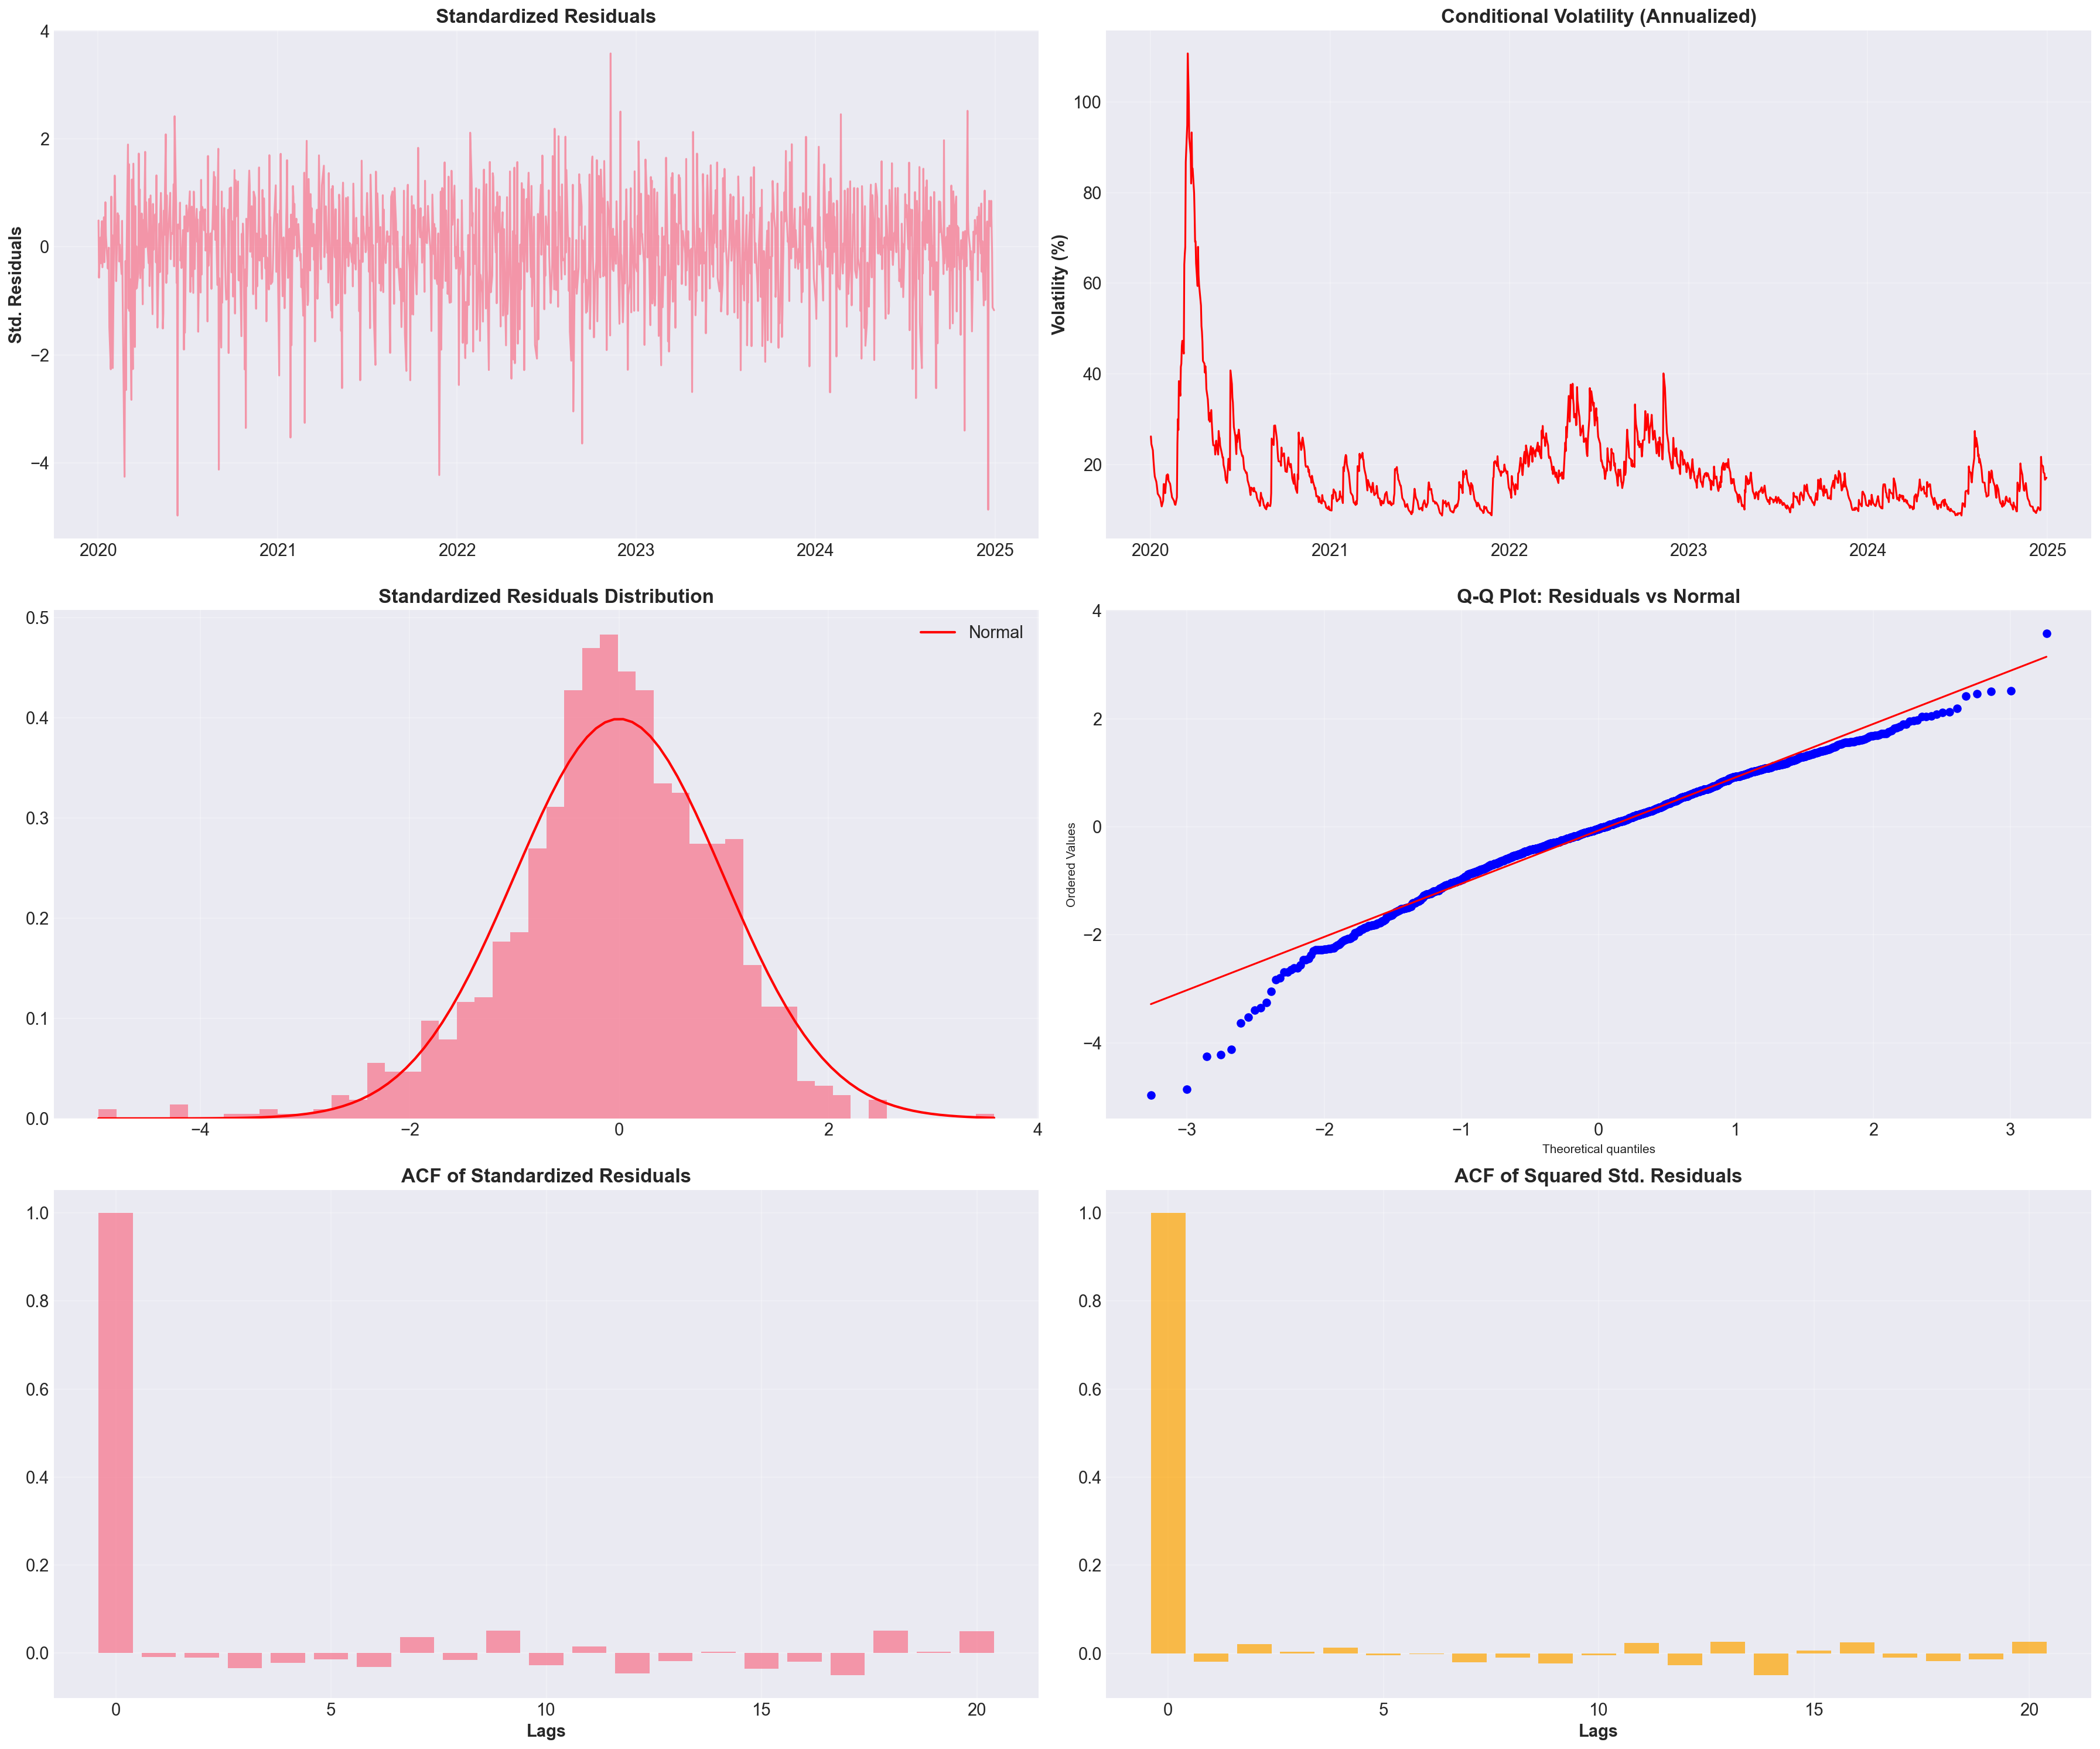

In [45]:
std_residuals, conditional_vols = model_diagnostics_plots(best_model_name, fitted_models)

The GARCH(1,1)-t model diagnostics confirm the model is performing across multiple validation criteria. The standardized residuals show no obvious patterns or clustering over time, while the conditional volatility appears to capture the major volatility regimes including the COVID spike, which exceeded 100% annualized volatility, and elevated periods during 2022. The standardized residuals distribution and Q-Q plot demonstrate that while some fat tails remain in the extreme quantiles, the model has substantially improved the distributional fit compared to the raw returns. Most importantly, the ACF plots of both standardized residuals and squared standardized residuals show minimal remaining autocorrelation, indicating the GARCH model has successfully captured the volatility clustering effects that were strongly present in the original data. These diagnostics act as strong validations of the GARCH(1,1)-t models ability to capture the S&P 500's time-varying volatility dynamics.

### 2.3 Best Model Statistical Tests

In [46]:
print(f"\033[1mResidual Diagnostics:\033[0m")

Residual Diagnostics:


In [47]:
best_model_stats = run_std_residuals_tests_on_best_model(std_residuals)

Jarque-Bera (normality): 208.4747 (p=0.000000)
Ljung-Box on squared residuals (ARCH): 0.989380


The post-estimation diagnostic tests confirm that the GARCH(1,1)-t model successfully handles the key issues identified in the raw data. While the Jarque-Bera test still rejects normality (statistic: 208.47, p=0.000000), this represents an improvement from the original statistic of 6930.67, and is an indicator the t-distribution has captured most of the fat tails in the return distribution. More importantly, the Ljung-Box test on squared residuals yields a low statistic of 0.989380, suggesting no significant remaining ARCH effects and confirming that the GARCH model has successfully eliminated the volatility clustering that was strongly present in the original data. These results validate that the model effectively captures the time-varying volatility dynamics while maintaining realistic distributional assumptions for financial returns.

## 3. Multivariate GARCH Model

### 3.1 Univariate Model Evaluation for Comparison and Correlation

In [48]:
print(f"As indicated above, additional tickers were loaded for evaluation: {ticker_list[1]}, {ticker_list[2]}, and {ticker_list[3]}.")

As indicated above, additional tickers were loaded for evaluation: TLT, GLD, and VXX.


In [49]:
asset_names = returns_df.columns.tolist()
univariate_models = create_univariate_models(asset_names, returns)

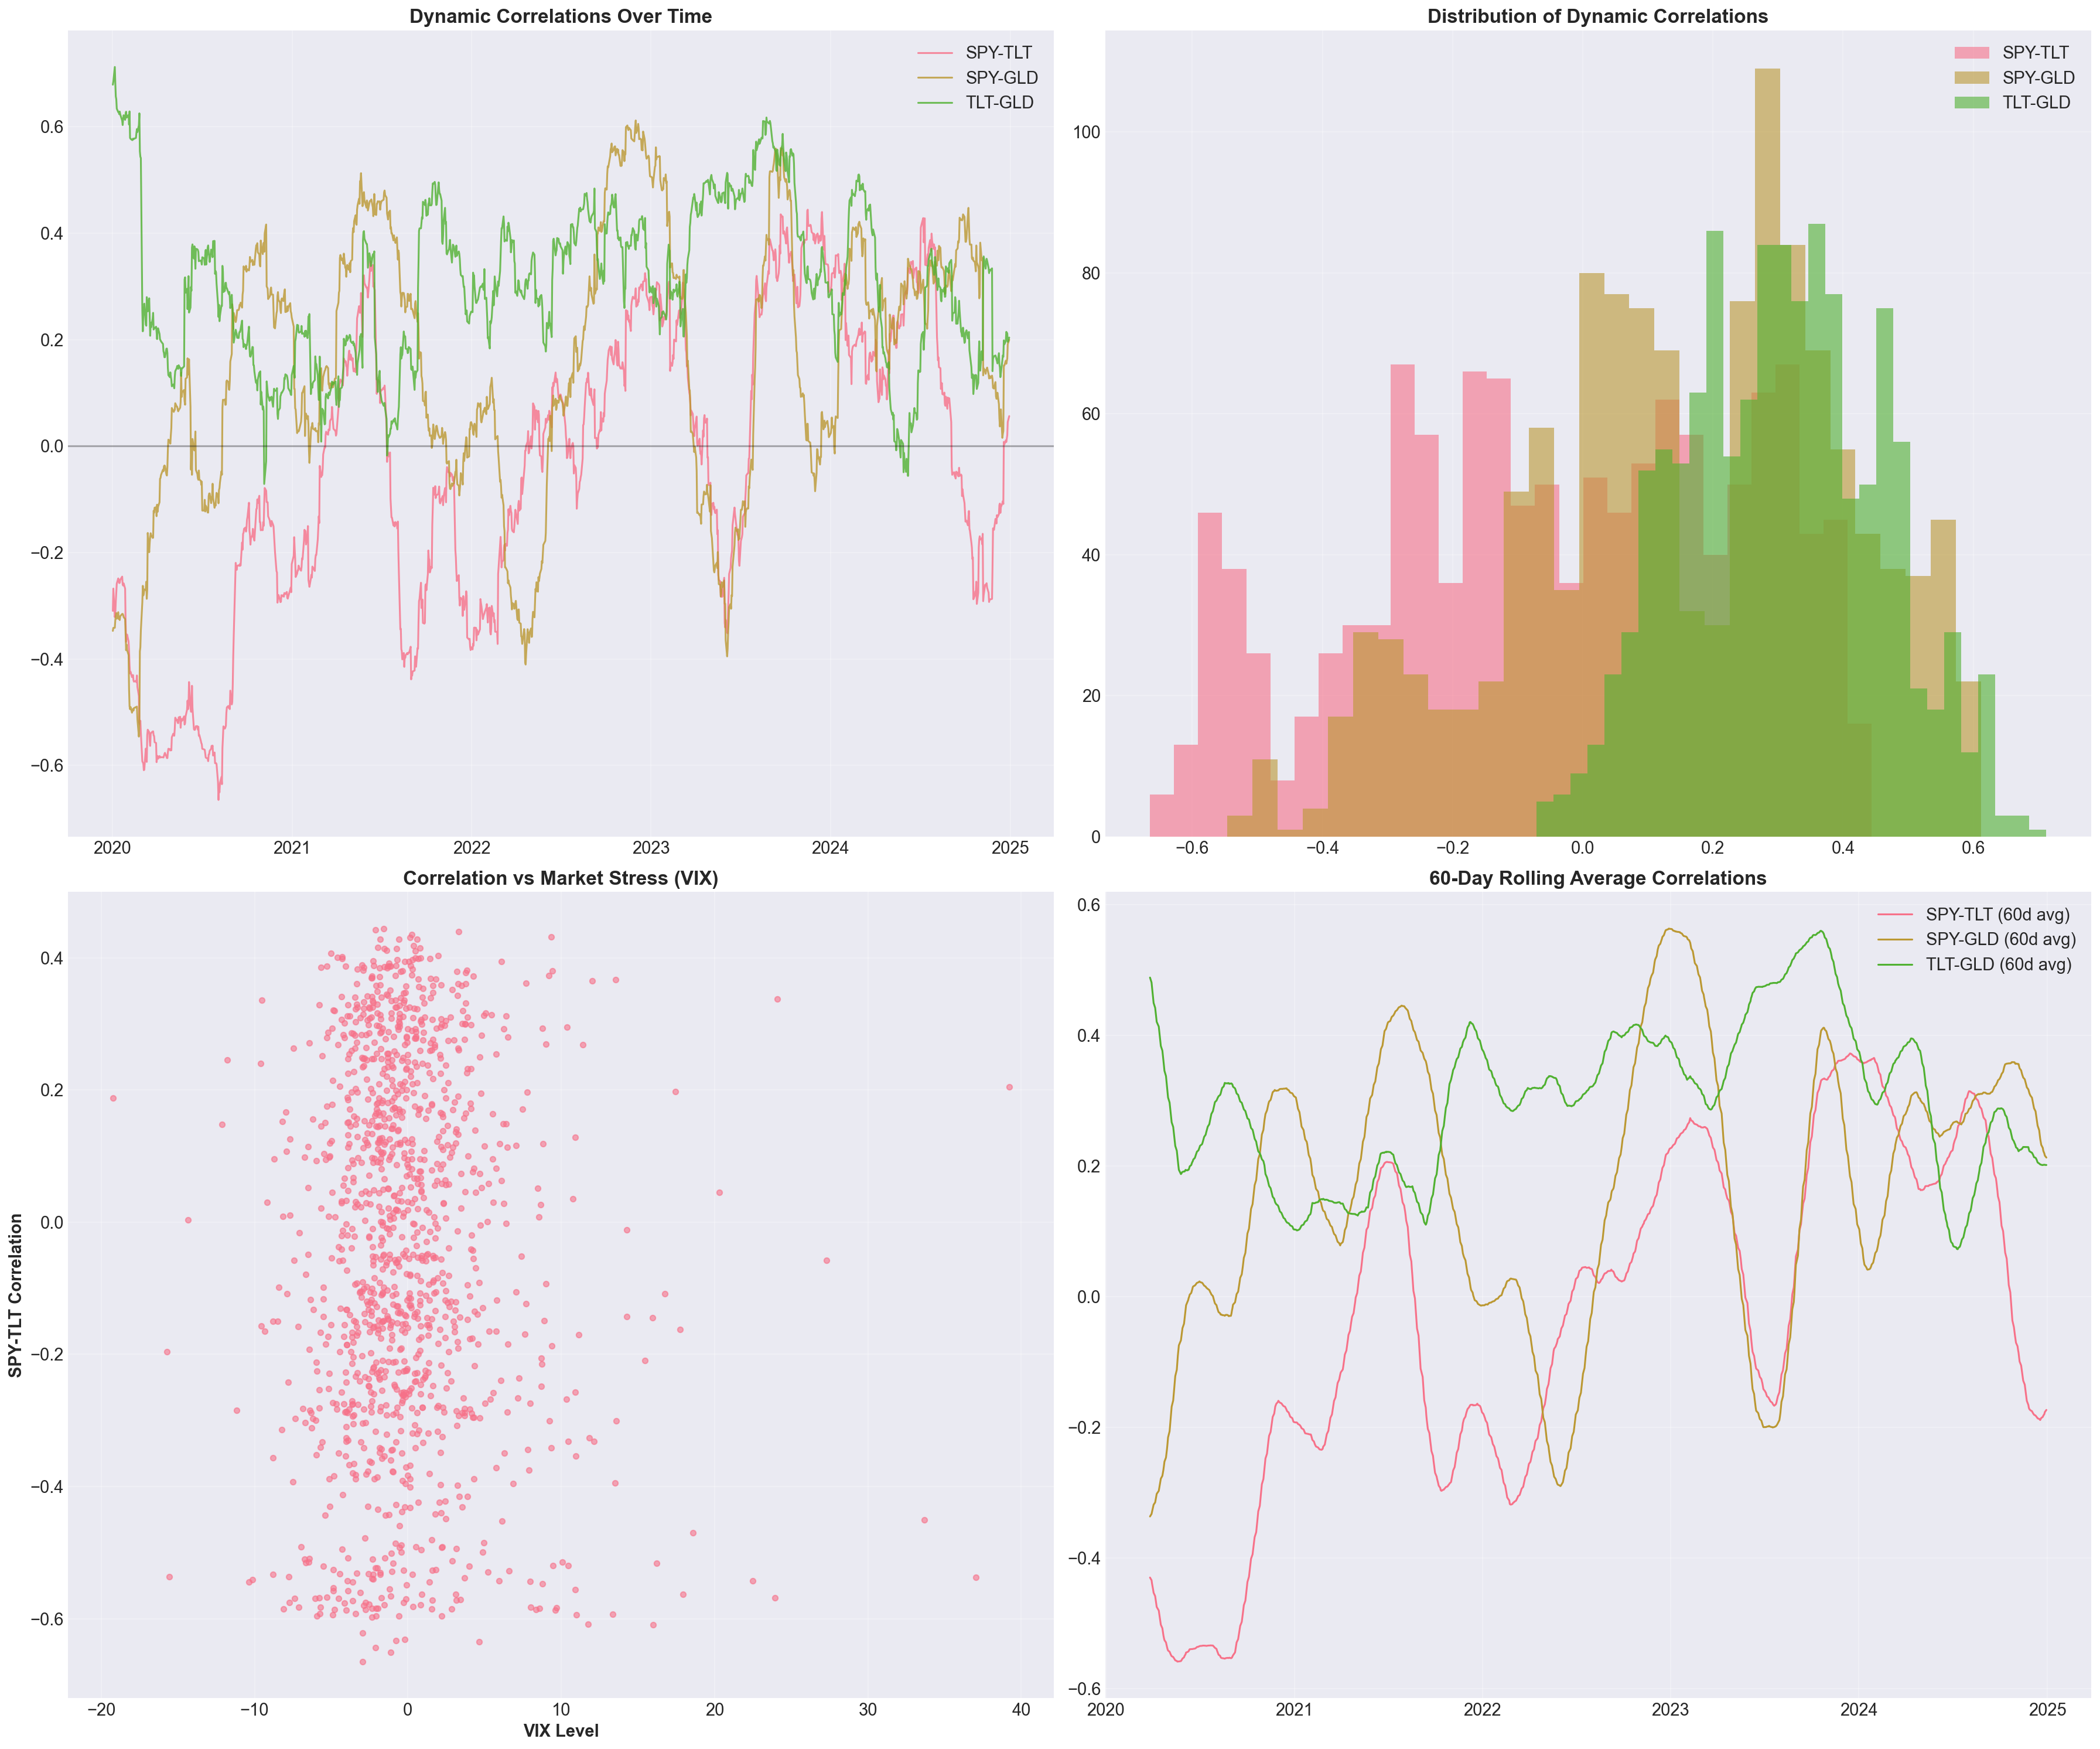

In [50]:
corr_df, corr_df_parsed, conditional_vols = generate_multivariate_garch_correlations(returns, univariate_models, asset_names, filter_date)
corr_df, vix_data, high_vix_periods = plot_multivariate_correlations(corr_df_parsed, returns_df)
# Create a writeup: what we're looking at and how this impacts the model going forward
# what the visuals mean and the conclusions that can be drawn from the statistics tests

The dynamic correlation analysis reveals that asset relationships are highly time-varying and regime-dependent, with SPY-TLT exhibiting the most dramatic shifts. The correlation between stocks and Treasury bonds swings from deeply negative (-0.6) during the 2020-2021 crisis period to positive correlations in calmer markets, demonstrating the classic "flight-to-quality" effect where bonds provide diversification exactly when portfolio protection is most needed. In contrast, SPY-GLD and TLT-GLD correlations remain relatively stable, clustering around zero to weakly positive levels, indicating these relationships are less sensitive to market regime changes.
The distribution analysis further confirms these patterns, with SPY-TLT showing a distinct bimodal distribution that reflects two separate correlation regimes rather than random variation around a mean. This regime-switching behavior could provide crisis protection during market stress while allowing both assets to contribute positive returns during normal market conditions. The correlation-VIX scatter plot validates this stress-dependent relationship, showing how correlations shift systematically with market volatility levels. Meanwhile, the more bell-shaped distributions of SPY-GLD and TLT-GLD correlations indicate these pairs offer more consistent, though modest, diversification benefits across all market conditions.


### 3.2 Crisis Analysis Correlations

In [51]:
print(f"\033[1mCorrelation During High VIX Periods (VIX > {vix_data.quantile(0.8):.1f})):\033[0m")

Correlation During High VIX Periods (VIX > 2.4)):


In [52]:
crisis_analysis = crisis_analysis(corr_df_parsed, high_vix_periods)

  SPY_TLT: Crisis=-0.080, Normal=-0.034, Difference=-0.046
  SPY_GLD: Crisis=0.140, Normal=0.155, Difference=-0.015
  TLT_GLD: Crisis=0.303, Normal=0.304, Difference=-0.001


The SPY-TLT correlation shows meaningful regime dependence, declining by -0.046 from normal to crisis periods, indicating the correlation becomes more negative during high VIX periods. This confirms the flight-to-quality effect as stocks and bonds move in a more opposite direction. As a result, only the SPY-TLT relationship shows meaningful regime dependence during high volatility periods. The SPY-GLD and TLT-GLD relationships remain relatively stable across market conditions as the correlations shifted only slightly. This validates bonds (TLT) as a more effective crisis hedge for equity positions than gold in this analysis period.

### 3.3 Conditional Volatility and Dynamic Coorelation Evaluation

In [53]:
print(f"\033[1mAverage Portfolio Correlations(SPY, TLT, GLD):\033[0m")

Average Portfolio Correlations(SPY, TLT, GLD):


In [54]:
 # Equal weight portfolio
weights = np.array([1/3, 1/3, 1/3])  # Equal weights for SPY, TLT, GLD

# Ensure conditional_vols order matches weights order (SPY, TLT, GLD)
conditional_vols_ordered = conditional_vols[['SPY', 'TLT', 'GLD']]  # Match weight order

# Calculate average correlations over the period
avg_spy_tlt = corr_df['SPY_TLT'].mean()
avg_spy_gld = corr_df['SPY_GLD'].mean() 
avg_tlt_gld = corr_df['TLT_GLD'].mean()

print(f"  SPY-TLT: {avg_spy_tlt:.3f}")
print(f"  SPY-GLD: {avg_spy_gld:.3f}")
print(f"  TLT-GLD: {avg_tlt_gld:.3f}")

  SPY-TLT: -0.043
  SPY-GLD: 0.152
  TLT-GLD: 0.304


In [55]:
print(f"\033[1mPortfolio Optimization and GARCH Comparison:\033[0m")

Portfolio Optimization and GARCH Comparison:


In [56]:
portfolio_vol_series, hist_vol = portfolio_volatility(conditional_vols, corr_df, returns)


Portfolio Optimization Using Dynamic Correlations:
Average Portfolio Volatility (DCC): 11.00%
Average Portfolio Volatility (Historical): 10.66%


In [57]:
print(f"\033[1mPortfolio Volatility Statistics and Visualization:\033[0m")

Portfolio Volatility Statistics and Visualization:


In [58]:
portfolio_analysis = portfolio_analysis(portfolio_vol_series)

Number of observations: 1257
Date range: 2020-01-02 to 2024-12-30
DCC Portfolio Volatility:
  Mean: 11.00%
  Std:  3.86%
  Min:  7.26%
  Max:  42.56%


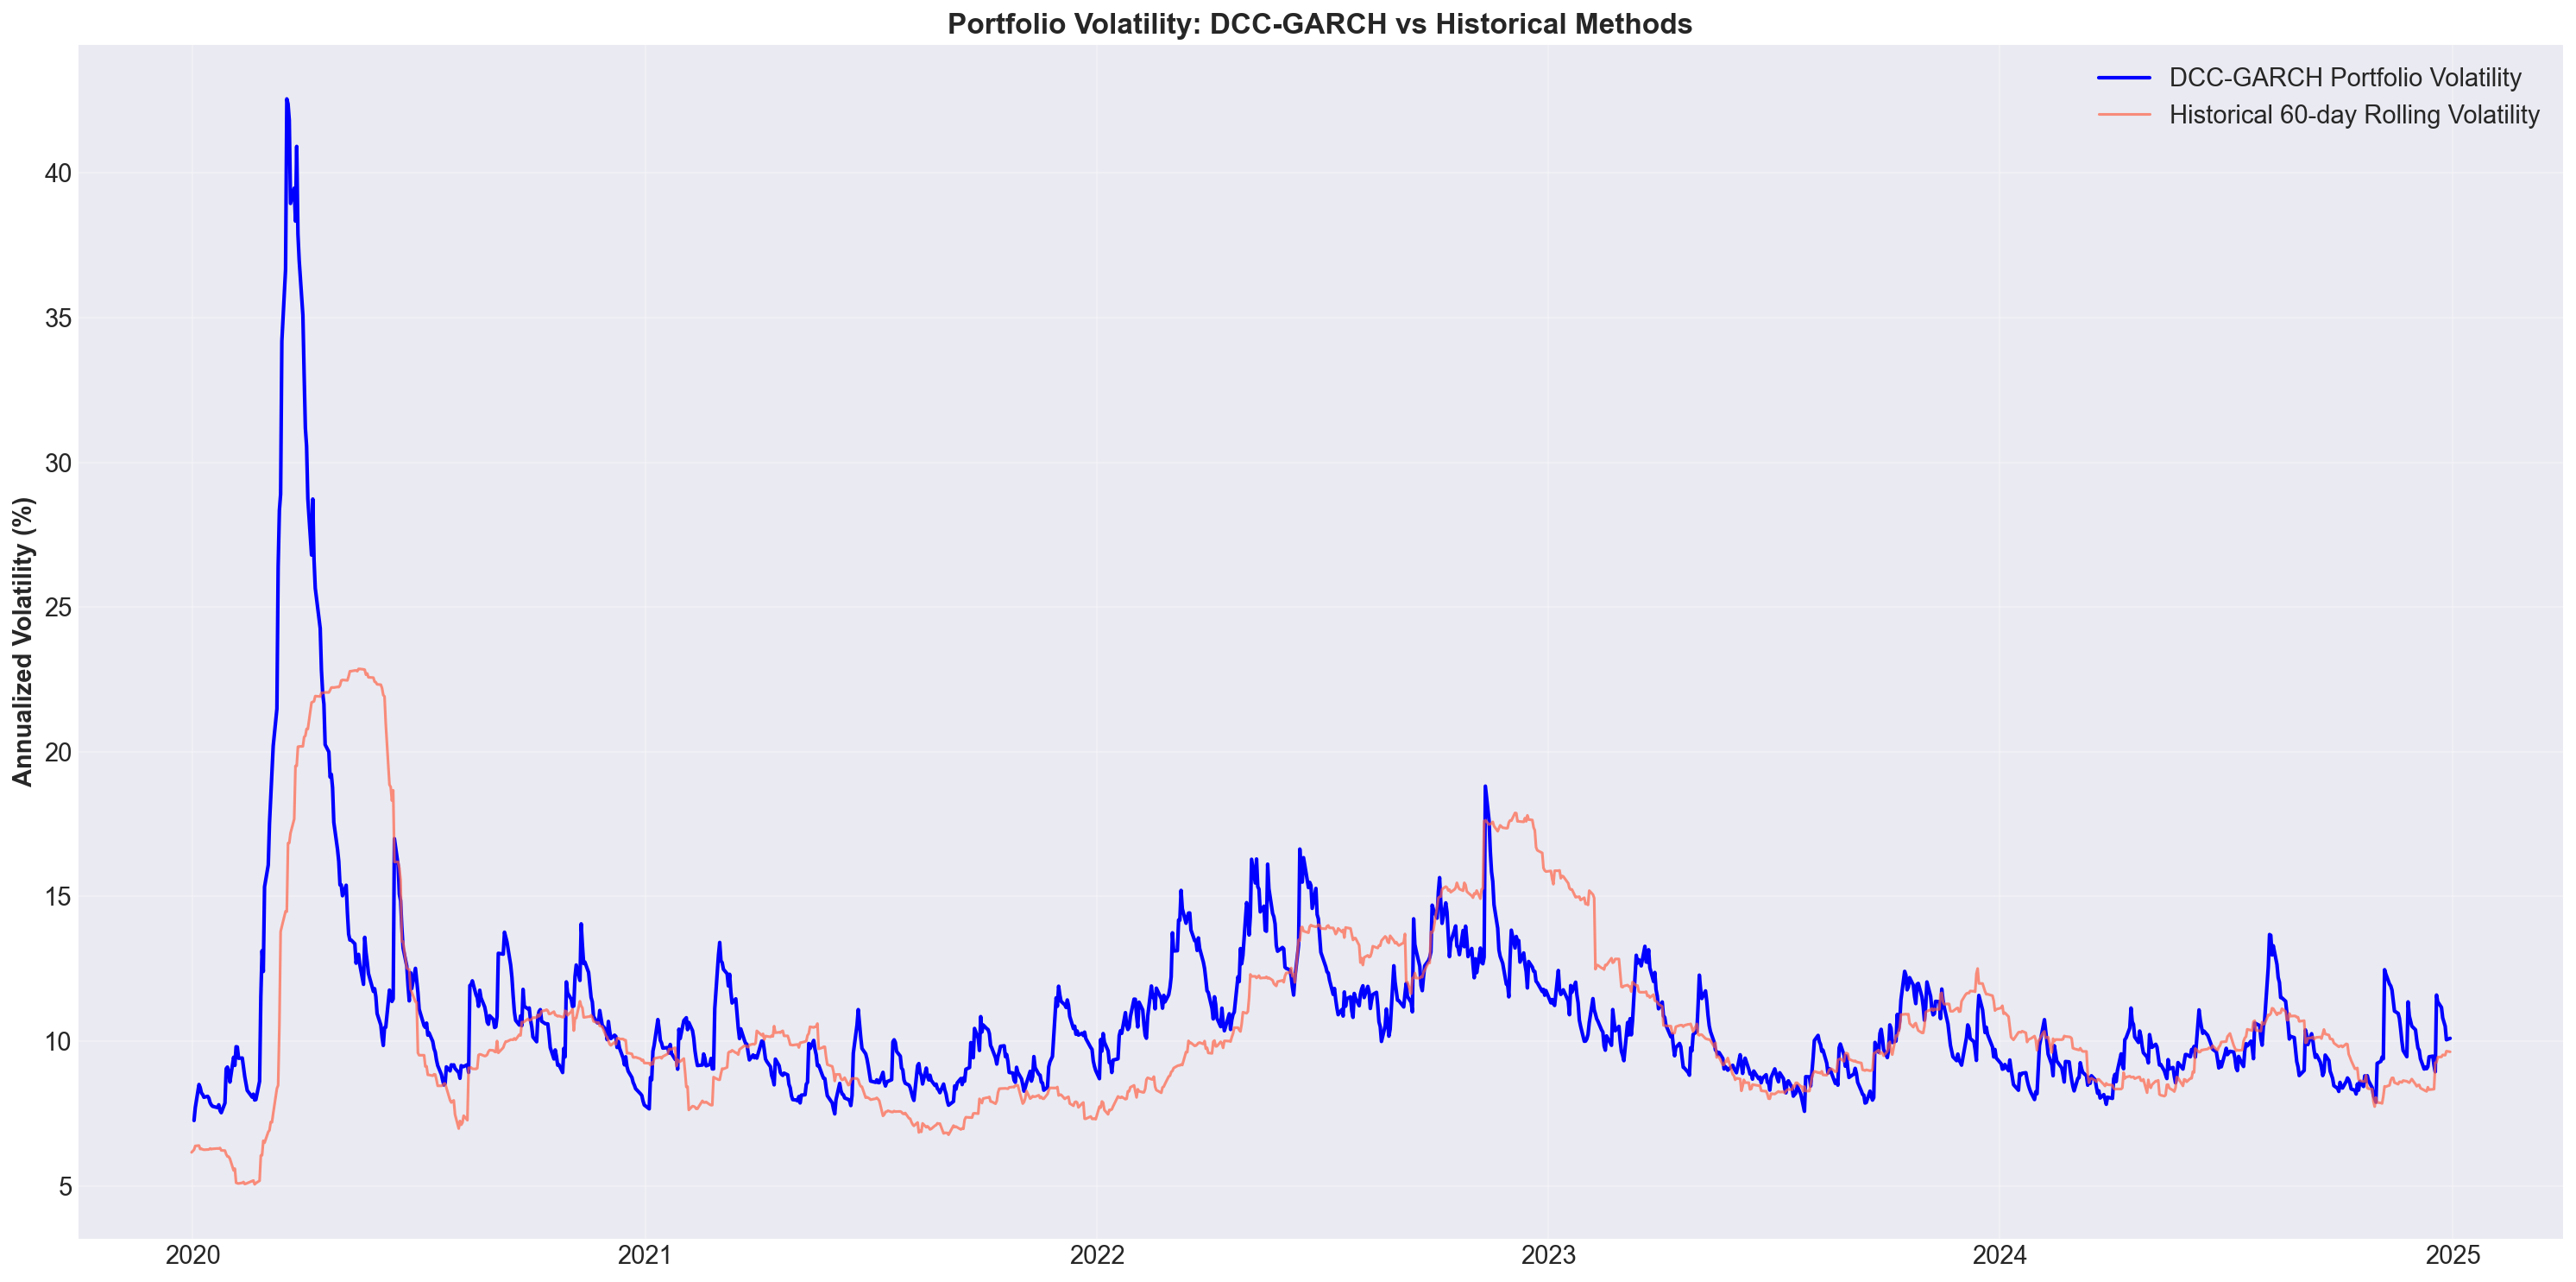

In [59]:
plot_conditional_volatility(portfolio_vol_series, hist_vol)

The average portfolio correlations reveal the diversification characteristics of the three-asset portfolio, with SPY-TLT showing a modest negative correlation of -0.043 that provides some hedging benefit, while SPY-GLD (0.152) and TLT-GLD (0.304) exhibit weak to moderate positive correlations. The portfolio optimization comparison demonstrates that dynamic correlation modeling produces remarkably similar results to historical methods, with DCC-based portfolio volatility averaging 11.00% compared to 10.66% for historical correlations. This close alignment suggests the portfolio construction is robust and that the dynamic correlation adjustments, while theoretically superior, don't dramatically alter the risk profile under normal market conditions.
The portfolio volatility statistics for this model span 1,257 observations from 2020-2024 and reveal significant regime variation, with portfolio volatility ranging from a minimum of 7.26% during calm periods to a maximum of 42.56% during the COVID crisis. The mean portfolio volatility of 11.00% with a standard deviation of 3.86% indicates that while the portfolio generally maintains moderate risk levels, it experiences substantial volatility clustering that mirrors the underlying market stress periods. This wide volatility range demonstrates how even a diversified three-asset portfolio remains sensitive to extreme market conditions, though the relatively low average volatility confirms that the diversification strategy effectively reduces risk compared to holding individual assets.


### 4. Rolling Window Forecast

In [60]:
# Function variables for simple rolling GARCH forecasting
window_size = 252  # 1 year
forecast_horizon = 30  # 30 days ahead
step = 10  # Forecast every 10 days

In [61]:
print(f"Simple Rolling GARCH Forecast")
print(f"Window size: {window_size} days")
print(f"Forecast horizon: {forecast_horizon} days")
print(f"Forecasting every {step} days")

Simple Rolling GARCH Forecast
Window size: 252 days
Forecast horizon: 30 days
Forecasting every 10 days


In [62]:
forecast_df = simple_rolling_forecast(returns_df['SPY'], window_size, forecast_horizon, step)


✓ Generated 98 forecasts


In [63]:
evaluate_forecast_accuracy = evaluate_forecast_accuracy(returns_df['SPY'], forecast_df)

Forecast Accuracy Metrics:
  Mean Absolute Error (MAE): 3.921%
  Root Mean Square Error (RMSE): 4.925%
  Mean Absolute Percentage Error (MAPE): 26.47%
  Correlation: 0.6863
  Direction Accuracy: 100.00%
  Number of Observations: 98


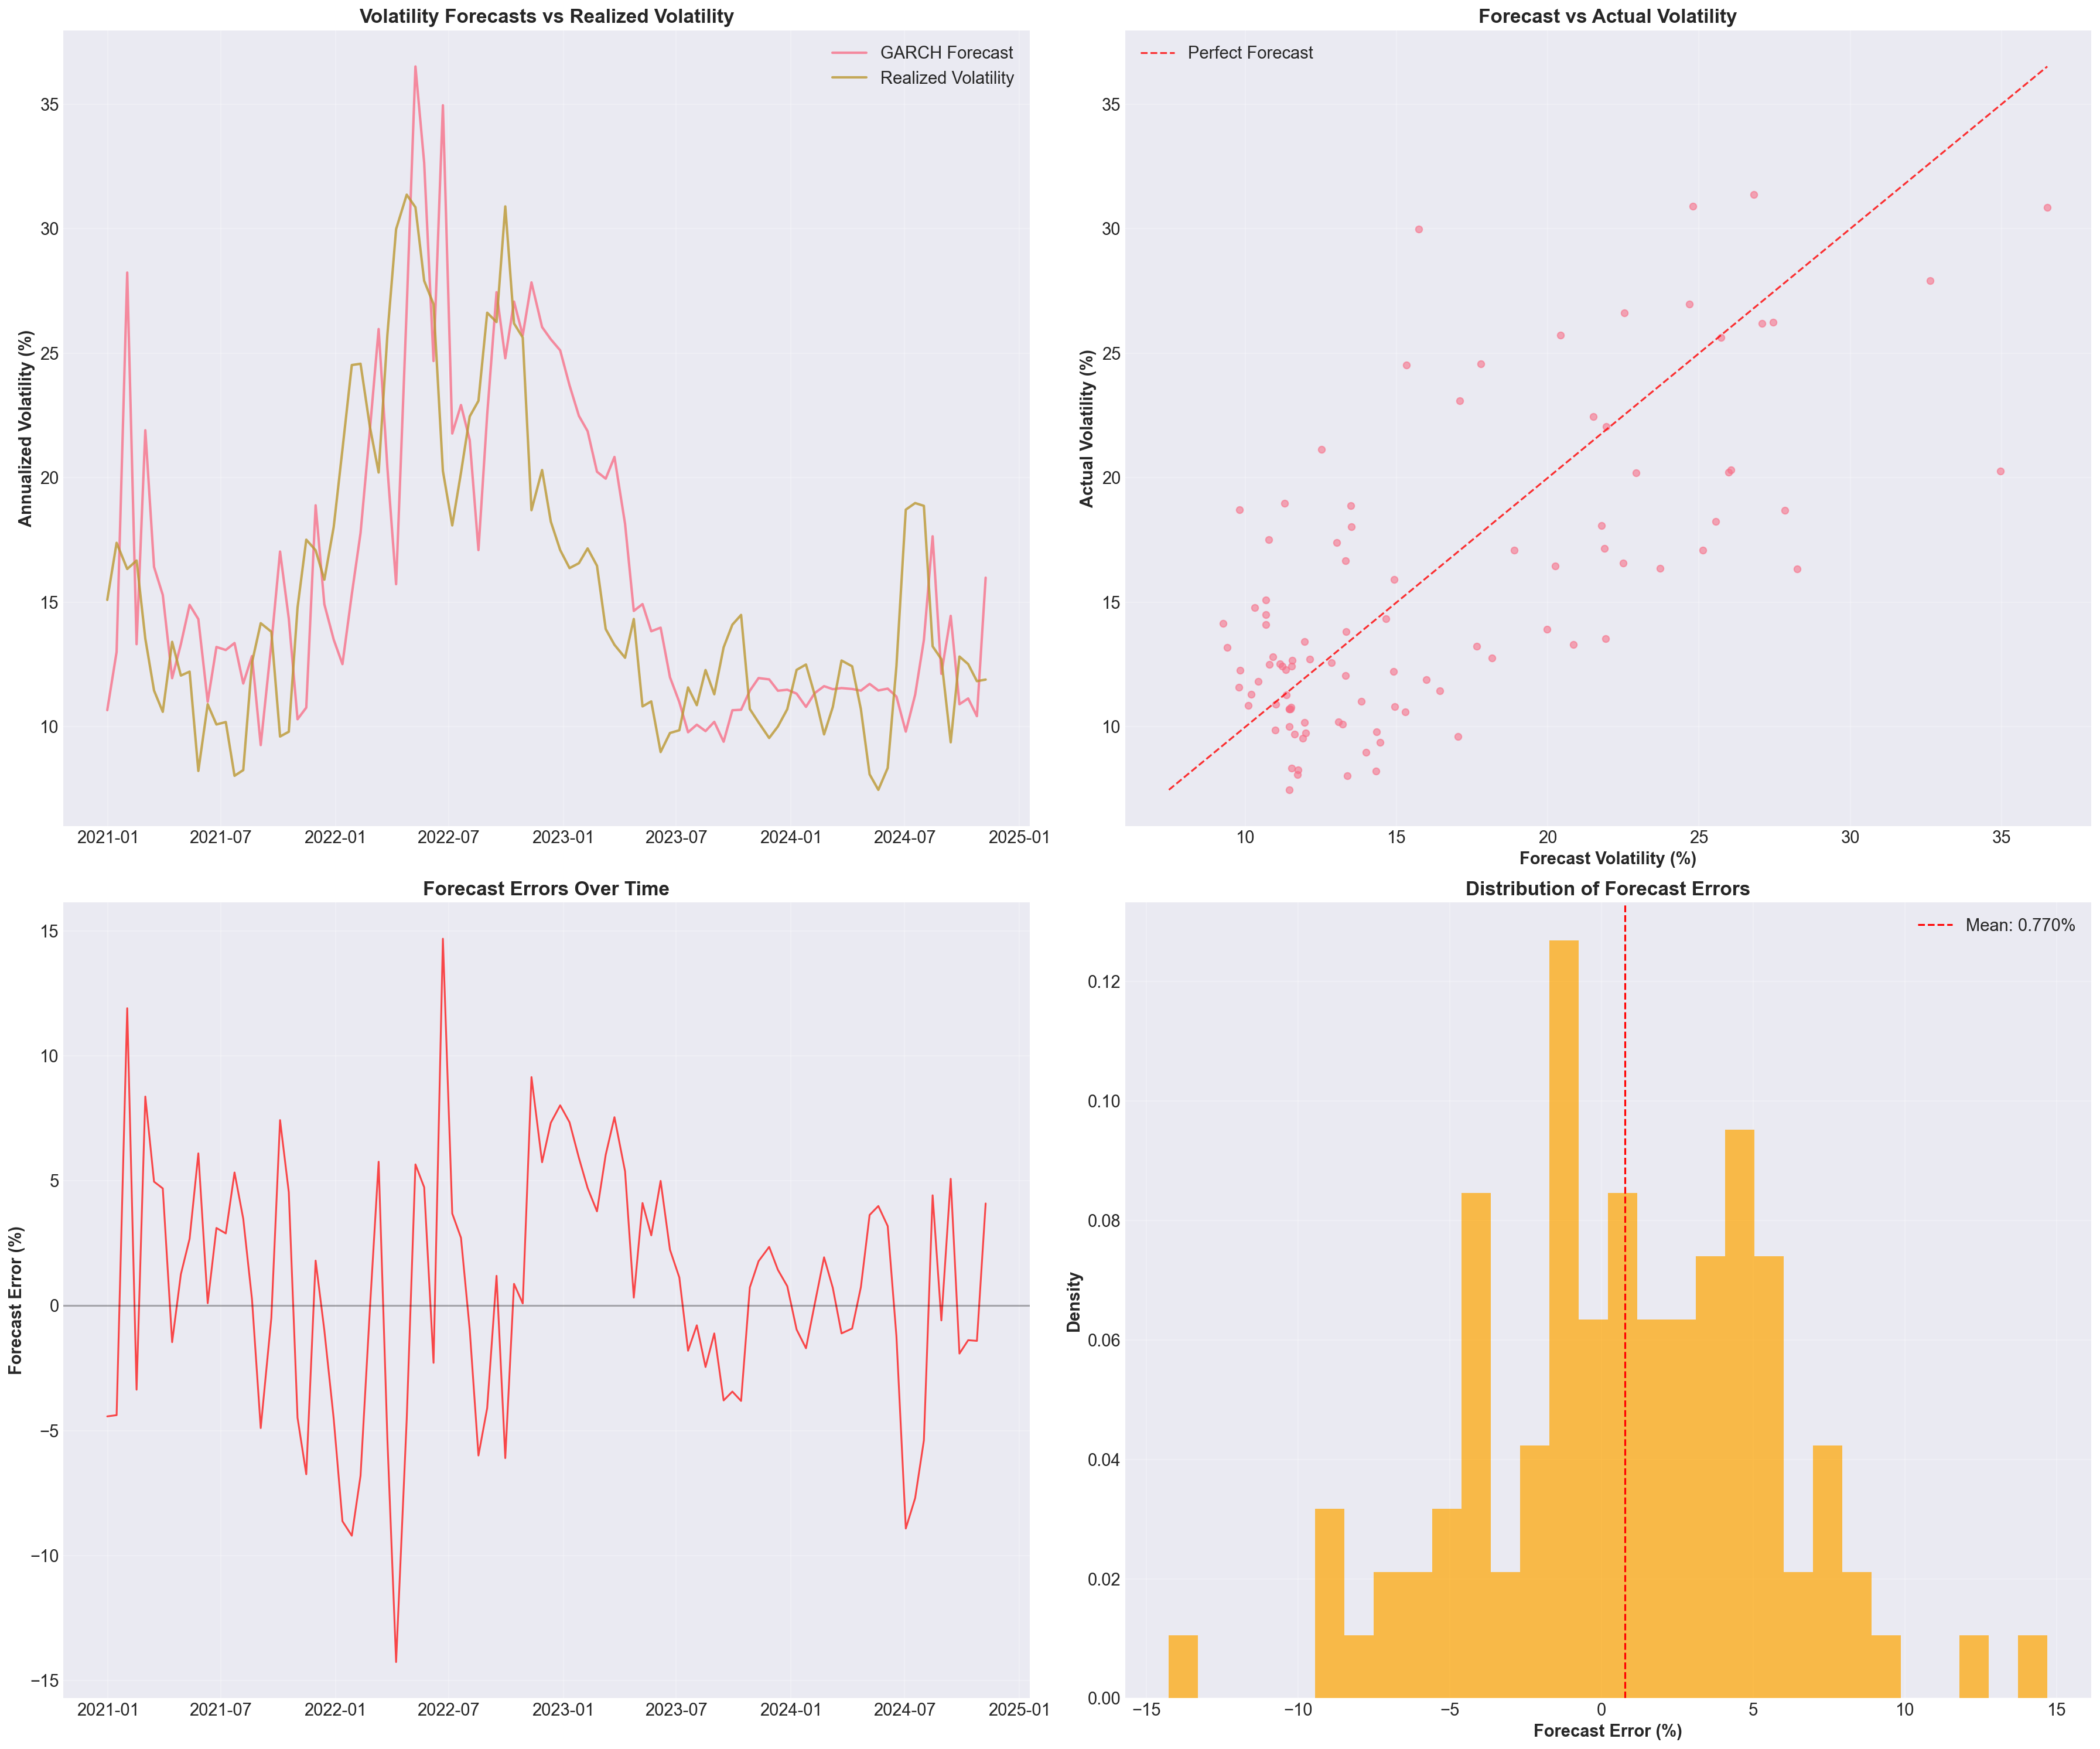

In [64]:
valid_data = plot_forecast_analysis(forecast_df)

### 5. RISK MANAGEMENT APPLICATIONS

In [65]:
portfolio_value=1000000
confidence_levels=[0.95, 0.99]
horizon=1
distribution='t'

In [66]:
var_results = calculate_portfolio_var(best_model, portfolio_value, confidence_levels, horizon, distribution)

Calculating Dynamic VaR (1-day horizon)
Confidence levels: [95, 99]%
Distribution: t
--------------------------------------------------
Volatility forecast: 1.117%
95% VaR: -2.171%
99% VaR: -3.511%
--------------------------------------------------

Portfolio VaR (Portfolio Value: $1,000,000)
--------------------------------------------------
95% VaR: -2.171% = $21,708
99% VaR: -3.511% = $35,109
--------------------------------------------------


In [67]:
var_summary_df = create_var_summary_table(var_results)


VaR Summary Table:
Confidence Level VaR (%) Volatility Forecast (%) VaR ($)
             95% -2.171%                  1.117% $21,708
             99% -3.511%                  1.117% $35,109

Interpretation:
• 5% chance of daily loss exceeding 2.17% ($21,708)
• 1% chance of daily loss exceeding 3.51% ($35,109)


In [68]:
simple_stress_testing = simple_stress_testing(best_model, returns_df['SPY'], portfolio_value=1000000)

STRESS TESTING SCENARIOS
Portfolio Value: $1,000,000

STRESS TEST RESULTS
--------------------------------------------------------------------------------

BASE CASE:
  Description: Normal market conditions (1-day GARCH forecast)
  Annual Volatility: 17.7%
  95% Daily VaR: -2.17% ($21,708)
  99% Daily VaR: -3.51% ($35,109)
  Expected Annual Loss: 7.1% ($70,937)

MODERATE STRESS:
  Description: 1.5x current market volatility
  Annual Volatility: 19.6%
  95% Daily VaR: -38.02% ($380,175)
  99% Daily VaR: -61.48% ($614,850)
  Expected Annual Loss: 7.8% ($78,258)

CRISIS 2008:
  Description: 2008-style financial crisis (45% volatility)
  Annual Volatility: 45.0%
  95% Daily VaR: -87.44% ($874,431)
  99% Daily VaR: -141.42% ($1,414,201)
  Expected Annual Loss: 27.0% ($270,000)

EXTREME COVID:
  Description: COVID-style market shock (60% volatility)
  Annual Volatility: 60.0%
  95% Daily VaR: -116.59% ($1,165,908)
  99% Daily VaR: -188.56% ($1,885,601)
  Expected Annual Loss: 48.0% ($480,000

Creating GARCH Risk Management Dashboard...


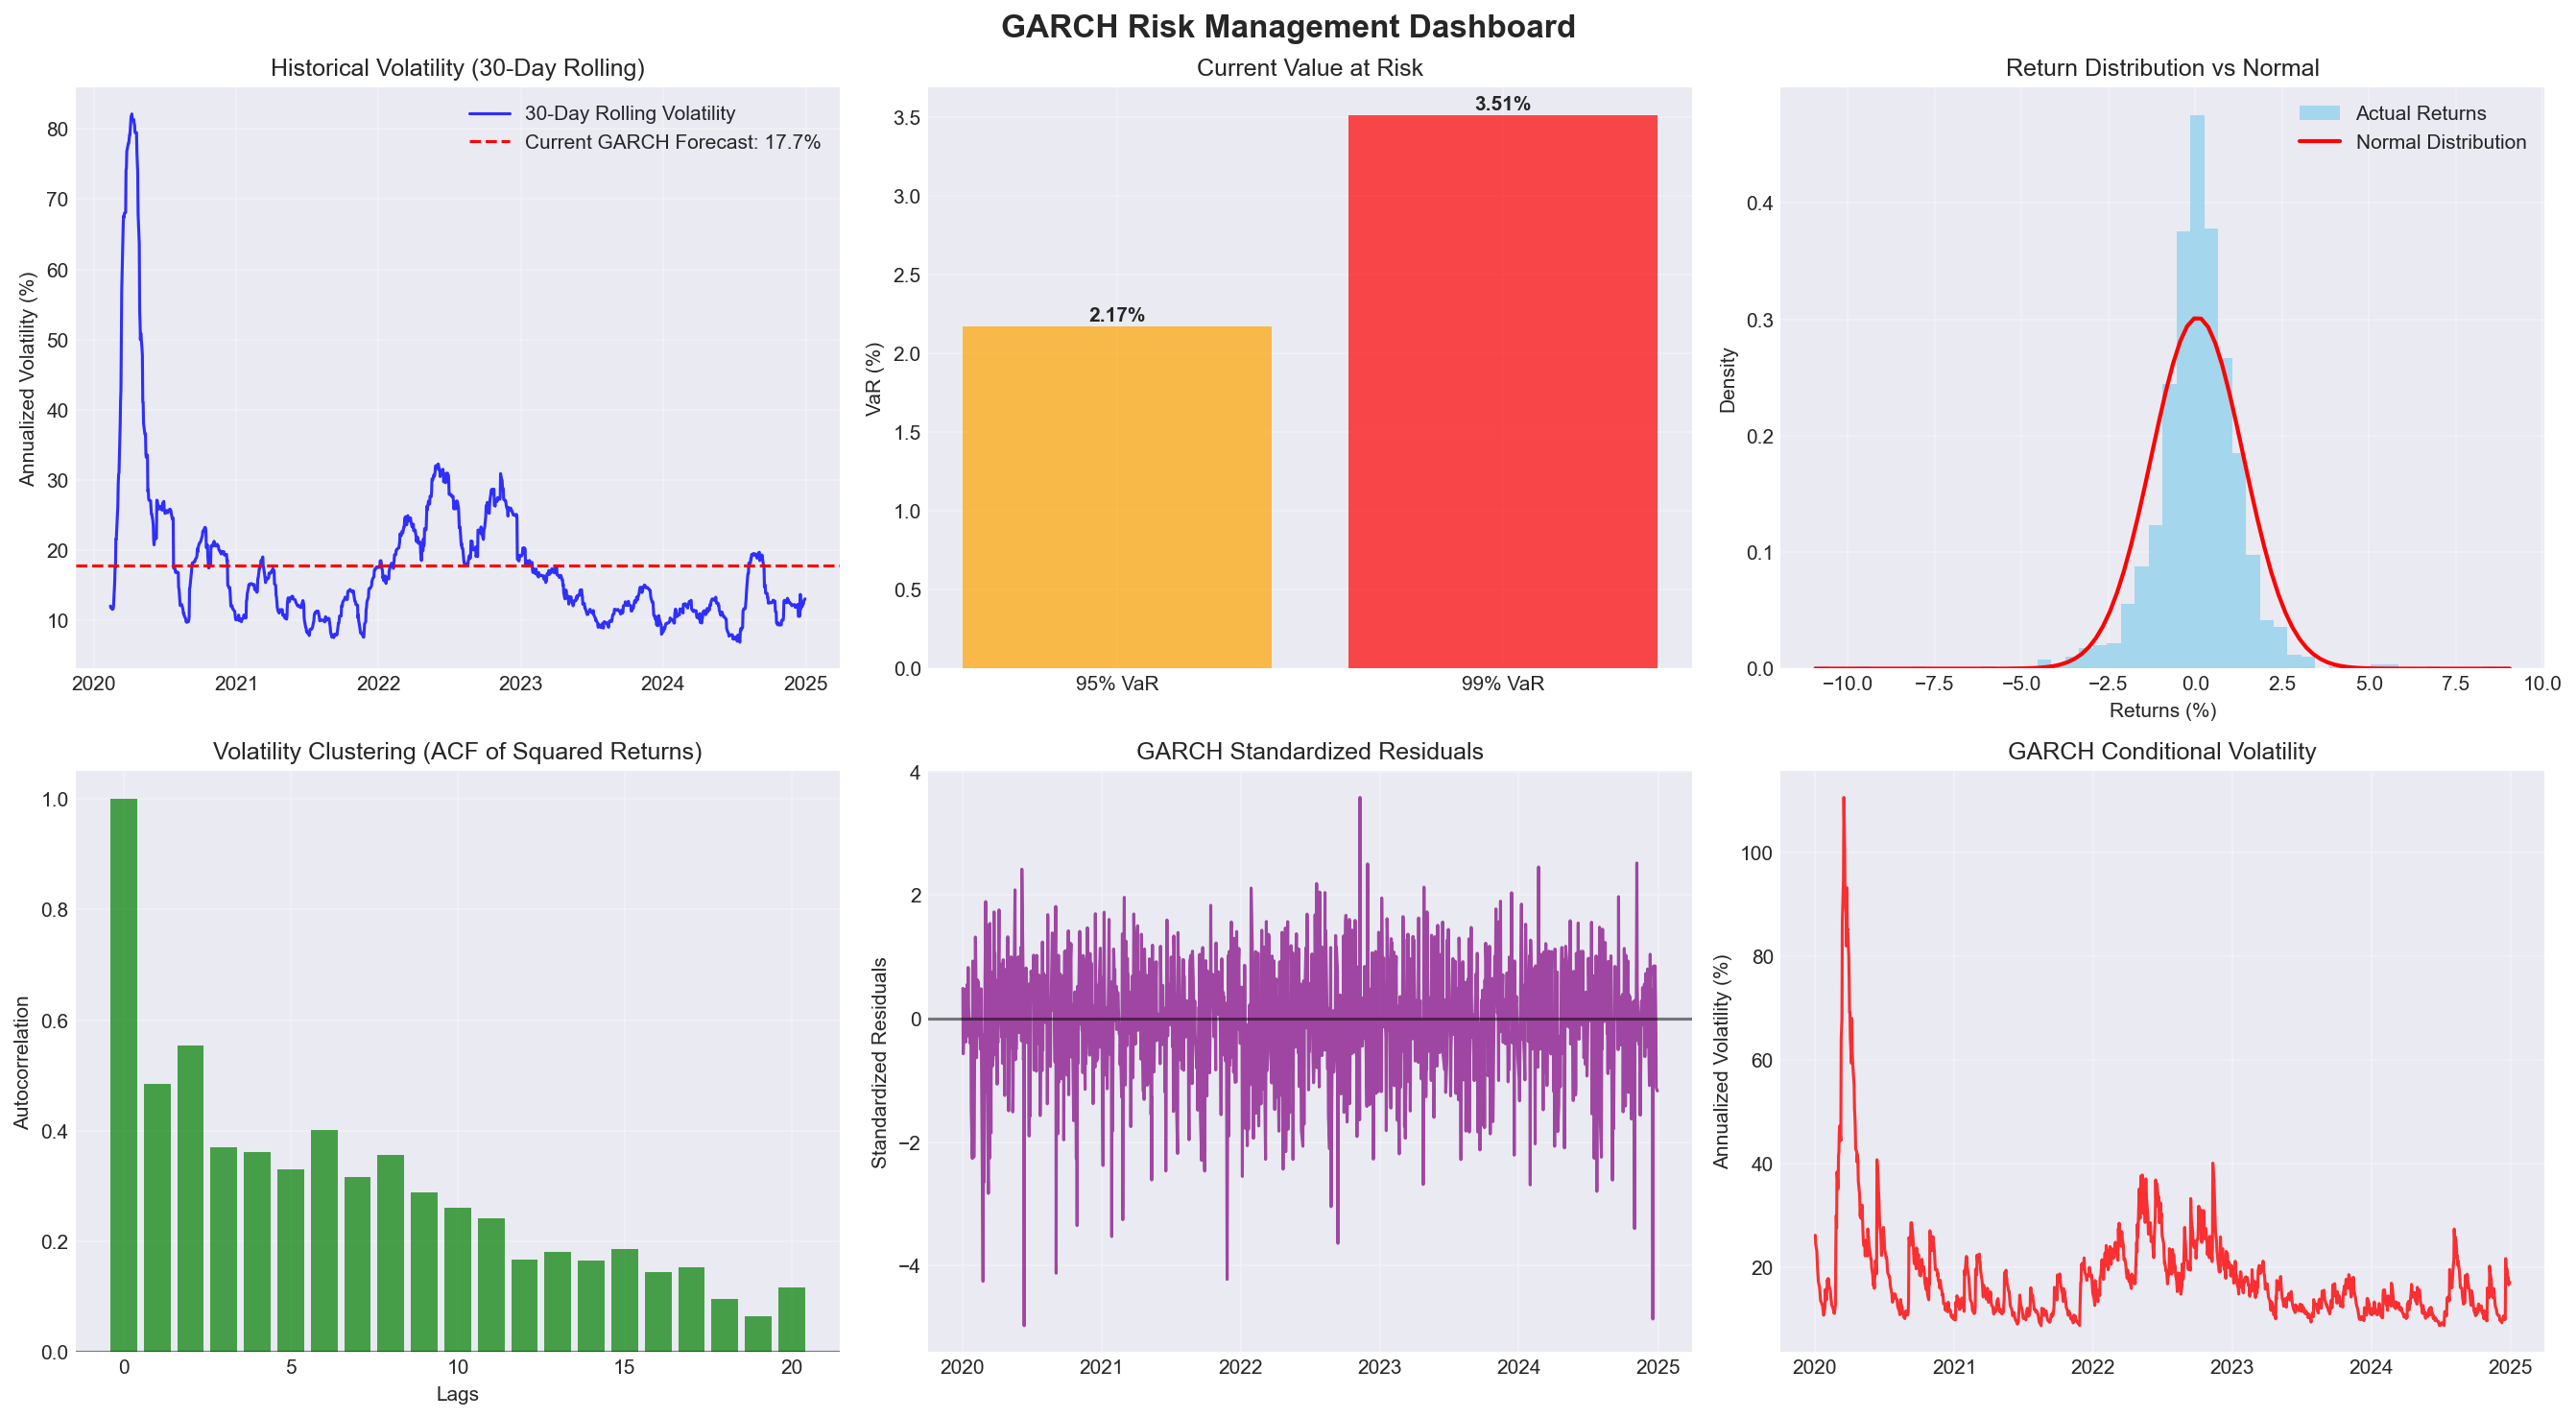


RISK DASHBOARD SUMMARY
Current Volatility Forecast: 17.73%
30-Day Realized Volatility: 13.04%
1-Year Realized Volatility: 12.57%

95% VaR (1-day): 2.17%
99% VaR (1-day): 3.51%

Risk Assessment:
🟡 MODERATE RISK: Current volatility elevated


In [69]:
risk_dashboard = create_simple_risk_dashboard(best_model, returns_df['SPY'], title="GARCH Risk Management Dashboard")

In [70]:
portfolio_risk_summary = create_portfolio_risk_summary(returns_df, portfolio_weights=None, asset_names=asset_names)


PORTFOLIO RISK SUMMARY
Individual Asset Volatilities:
  SPY: 21.00% (Weight: 25.0%)
  TLT: 17.97% (Weight: 25.0%)
  GLD: 15.53% (Weight: 25.0%)
  VXX: 75.92% (Weight: 25.0%)

Portfolio Volatility: 17.27%

Correlation Matrix:
       SPY    TLT    GLD    VXX
SPY  1.000 -0.150  0.158 -0.710
TLT -0.150  1.000  0.267  0.129
GLD  0.158  0.267  1.000 -0.095
VXX -0.710  0.129 -0.095  1.000

Diversification Analysis:
  Weighted Average Volatility: 32.60%
  Portfolio Volatility: 17.27%
  Diversification Benefit: 15.33%
